# Check Pay rate Knit Away
Dạo gần đây pay rate của game có xu hướng giảm, team giúp em check xem hiện tại chỉ số đang giảm ntn? có chỉ số nào khác giảm dẫn tới hệ lụy giảm payrate ko? tại sao payrate giảm?
Đặc biệt, 16/11 count IAP tăng, nhưng rev và unique purchaser giảm so với 15/11, team check giúp em cơ cấu gói bán 16/11 ntn so với 15/11 nhé ạ

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, MultipleLocator
import seaborn as sns
import datetime
from google.cloud import bigquery

C:\Users\PC\PycharmProjects\PythonProject\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [3]:
client = bigquery.Client()

In [37]:
active_users = """
SELECT
    user_pseudo_id,
    event_date,
    version,
    platform,
    country
FROM `wool-away.knit_away_flatten.user_fact`
WHERE event_name IN ('start_level', 'session_start', 'screen_view', 'user_engagement', 'app_exception', 'first_open', 'app_remove')
    AND version >= '1.6.4'
    AND event_date BETWEEN '2025-10-27' AND '2025-11-18'
GROUP BY ALL
"""
active_users = client.query(active_users).to_dataframe()

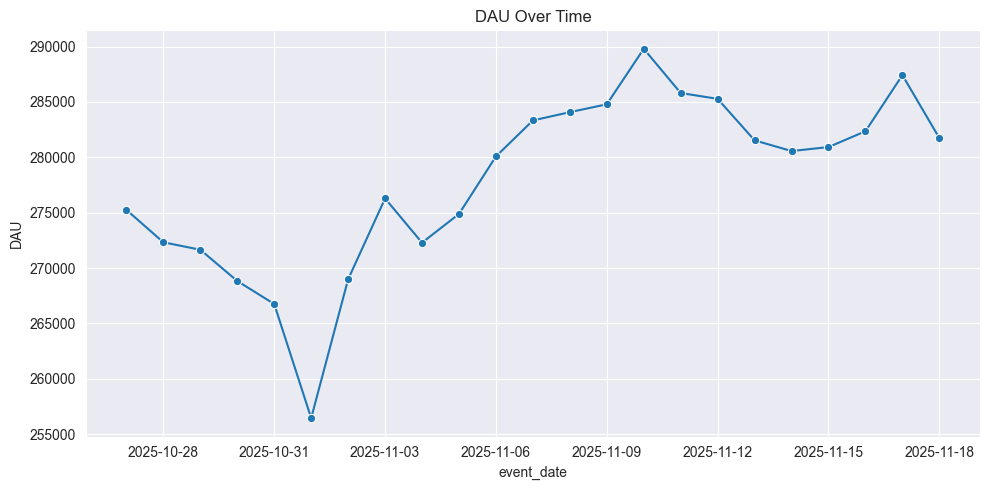

In [4]:
dau = active_users.groupby(['event_date']).agg(
    dau = ('user_pseudo_id', 'nunique')
).reset_index()
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=dau, x='event_date', y='dau', marker='o', ax=ax)
ax.set_title('DAU Over Time')
ax.set_ylabel('DAU')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

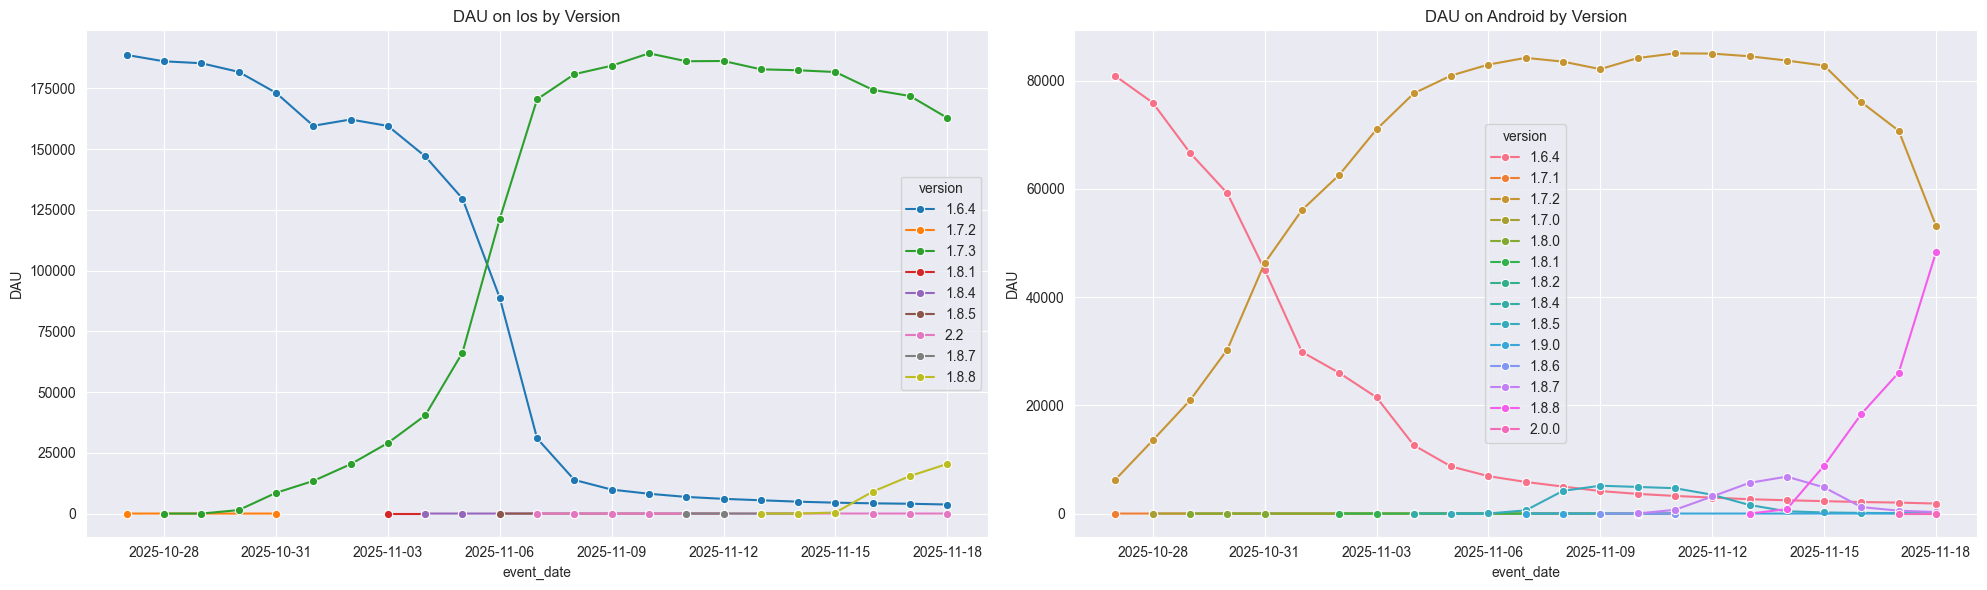

In [5]:
dau_platform_version = active_users.groupby(['event_date', 'platform', 'version']).agg(
    dau = ('user_pseudo_id', 'nunique')
).reset_index()
fig, ax = plt.subplots(1,2, figsize=(20,6))
platform = ['IOS', 'ANDROID']
for i, p in enumerate(platform):
    data = dau_platform_version[dau_platform_version['platform'] == p]
    sns.lineplot(data=data, x='event_date', y='dau', hue='version', marker='o', ax=ax[i])
    ax[i].set_title(f'DAU on {p.capitalize()} by Version')
    ax[i].set_ylabel('DAU')
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [38]:
iap = """
SELECT * EXCEPT(ga_session_id, ga_session_number, price, currency, quantity, value)
FROM `wool-away.knit_away_flatten.in_app_purchase`
WHERE version >= '1.6.4'
    AND event_date BETWEEN '2025-10-27' AND '2025-11-18'
"""
iap = client.query(iap).to_dataframe()

In [7]:
iap_daily = iap.groupby(['event_date']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count')
).reset_index()

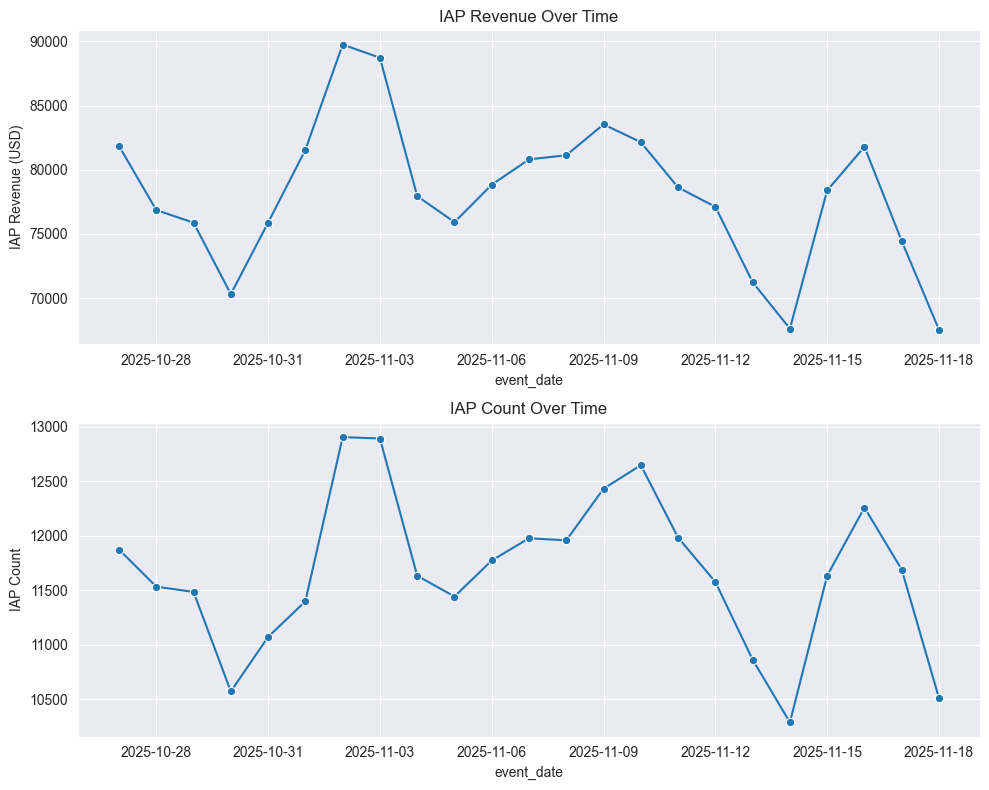

In [8]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
sns.lineplot(data=iap_daily, x='event_date', y='iap_revenue', marker='o', ax=ax[0])
ax[0].set_title('IAP Revenue Over Time')
ax[0].set_ylabel('IAP Revenue (USD)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(data=iap_daily, x='event_date', y='iap_count', marker='o', ax=ax[1])
ax[1].set_title('IAP Count Over Time')
ax[1].set_ylabel('IAP Count')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

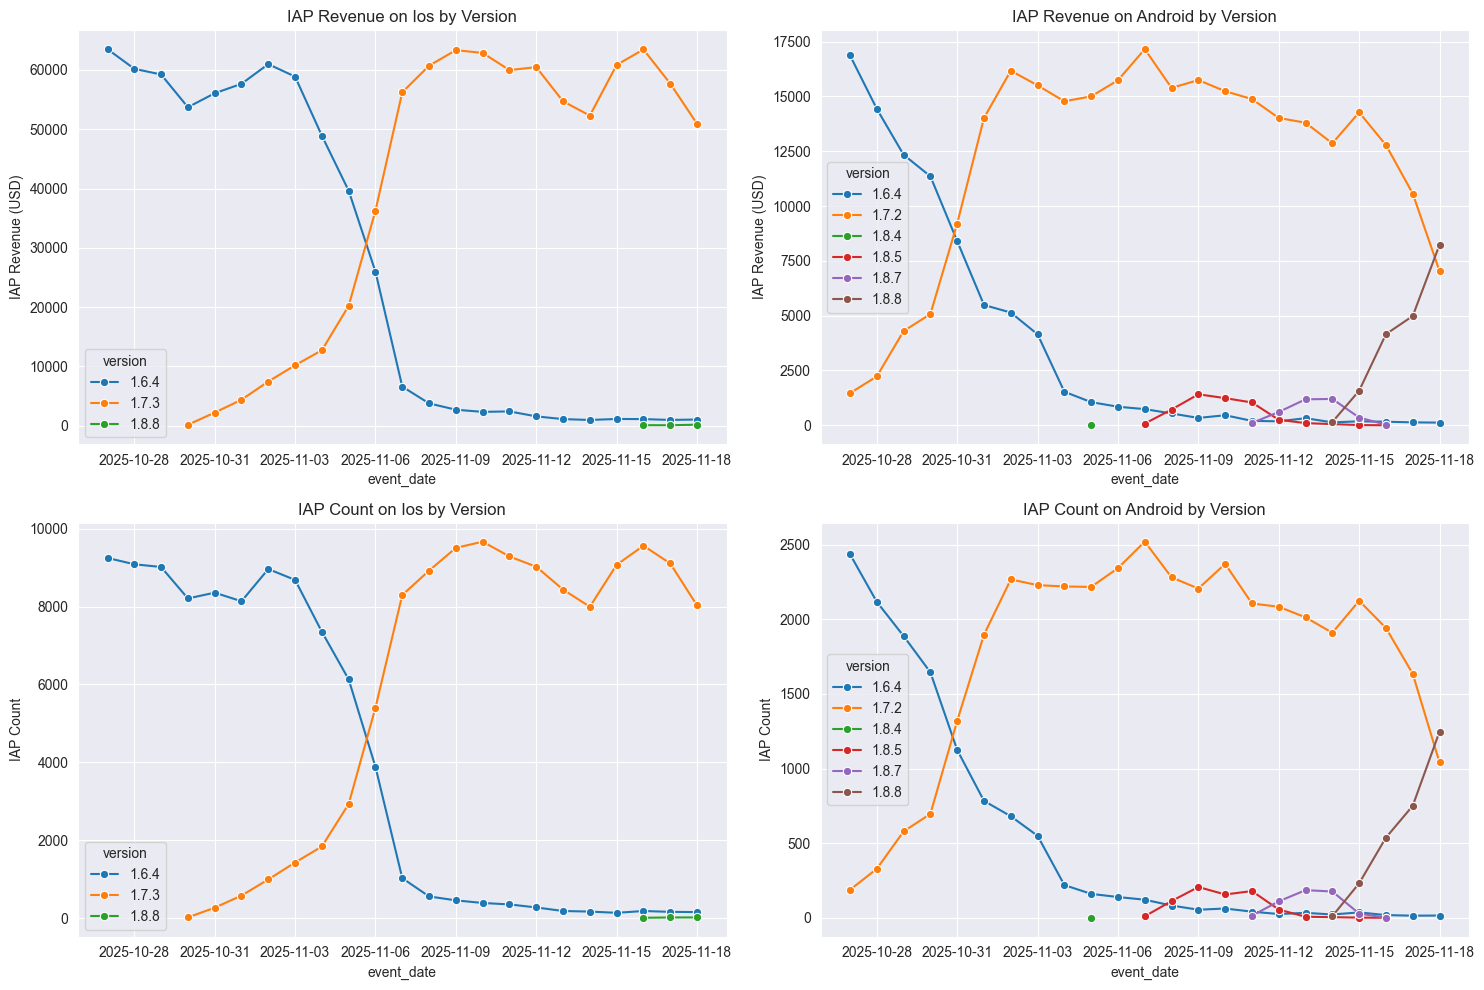

In [9]:
iap_platform_version = iap.groupby(['event_date', 'platform', 'version']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count')
).reset_index()
fig, ax = plt.subplots(2,2, figsize=(15,10))
platform = ['IOS', 'ANDROID']
for i, p in enumerate(platform):
    data = iap_platform_version[iap_platform_version['platform'] == p]
    sns.lineplot(data=data, x='event_date', y='iap_revenue', hue='version', marker='o', ax=ax[0,i])
    ax[0,i].set_title(f'IAP Revenue on {p.capitalize()} by Version')
    ax[0,i].set_ylabel('IAP Revenue (USD)')
    ax[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
    sns.lineplot(data=data, x='event_date', y='iap_count', hue='version', marker='o', ax=ax[1,i])
    ax[1,i].set_title(f'IAP Count on {p.capitalize()} by Version')
    ax[1,i].set_ylabel('IAP Count')
    ax[1,i].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [10]:
iap_users_daily = iap.groupby(['event_date']).agg(
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()
active_users_daily = active_users.groupby(['event_date']).agg(
    active_users = ('user_pseudo_id', 'nunique')
).reset_index()
pay_rate_daily = pd.merge(iap_users_daily, active_users_daily, on='event_date', how='left')
pay_rate_daily['pay_rate'] = pay_rate_daily['iap_users'] / pay_rate_daily['active_users']

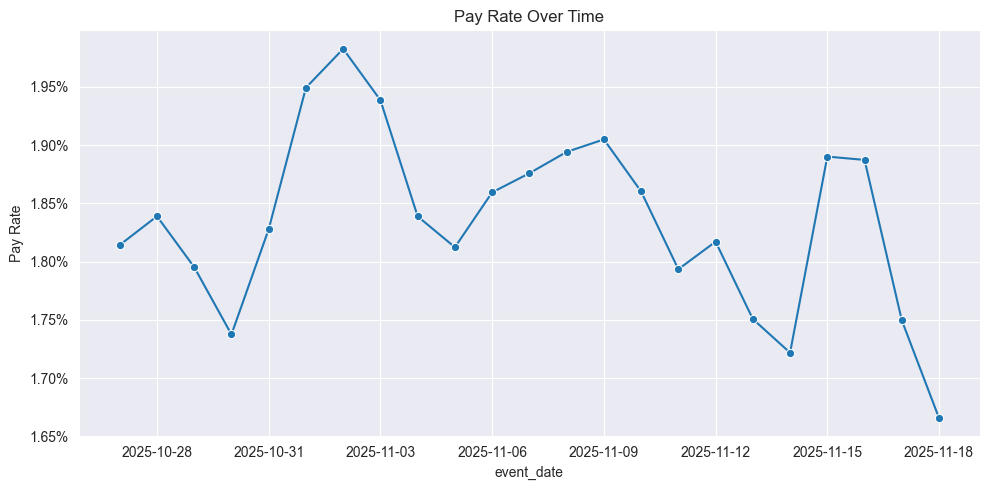

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=pay_rate_daily, x='event_date', y='pay_rate', marker='o', ax=ax)
ax.set_title('Pay Rate Over Time')
ax.set_ylabel('Pay Rate')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.tight_layout()
plt.show()

In [12]:
iap_users_platform_version = iap[iap['version'].isin(['1.6.4', '1.7.3', '1.7.2'])].groupby(['event_date', 'platform', 'version']).agg(iap_users = ('user_pseudo_id', 'nunique')
).reset_index()
active_users_platform_version = active_users[active_users['version'].isin(['1.6.4', '1.7.3', '1.7.2'])].groupby(['event_date', 'platform', 'version']).agg(    active_users = ('user_pseudo_id', 'nunique')
).reset_index()
pay_rate_platform_version = pd.merge(iap_users_platform_version, active_users_platform_version, on=['event_date', 'platform', 'version'], how='left')
pay_rate_platform_version['pay_rate'] = pay_rate_platform_version['iap_users'] / pay_rate_platform_version['active_users']

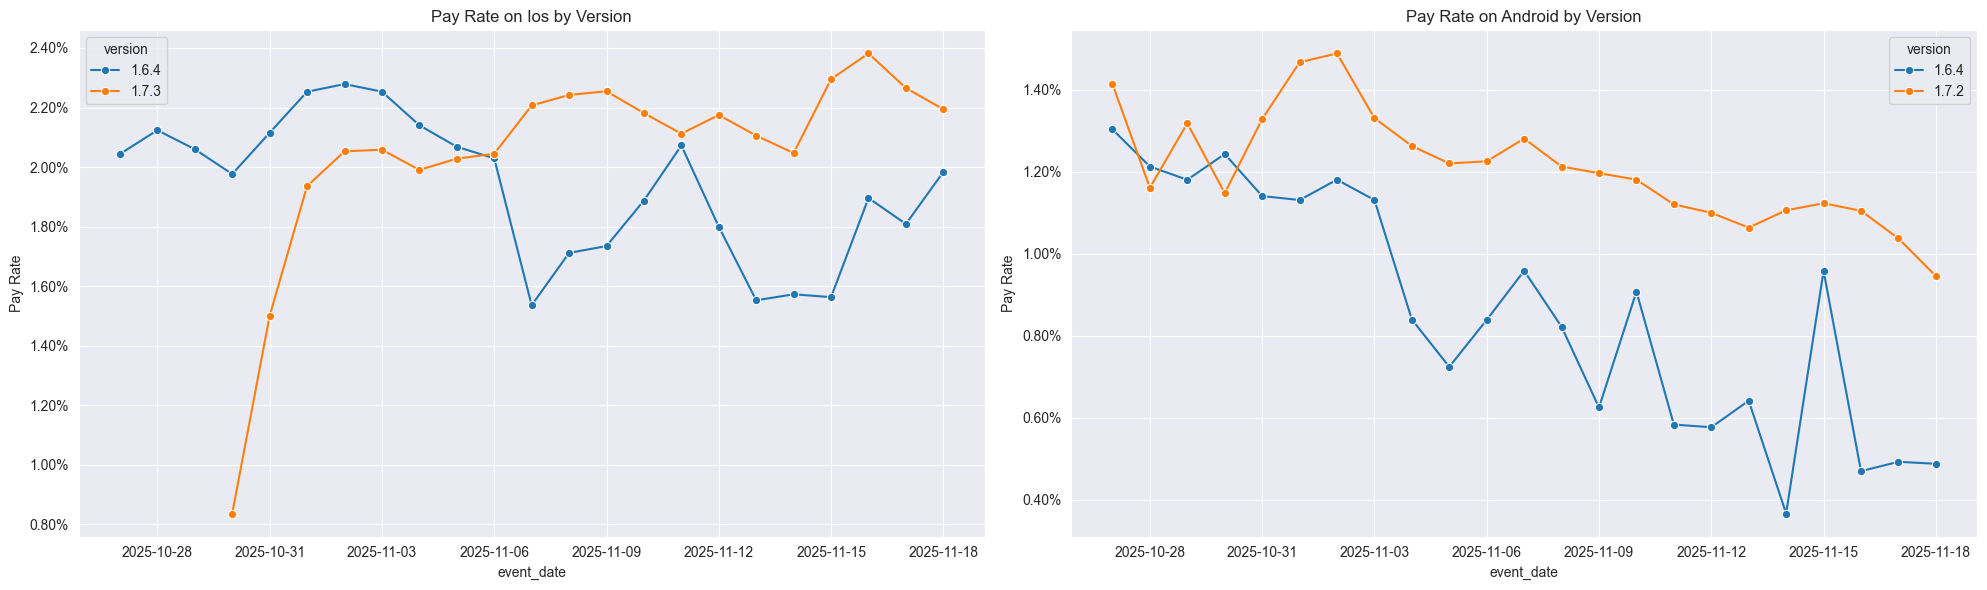

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
platform = ['IOS', 'ANDROID']
for i, p in enumerate(platform):
    data = pay_rate_platform_version[pay_rate_platform_version['platform'] == p]
    sns.lineplot(data=data, x='event_date', y='pay_rate', hue='version', marker='o', ax=ax[i])
    ax[i].set_title(f'Pay Rate on {p.capitalize()} by Version')
    ax[i].set_ylabel('Pay Rate')
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.tight_layout()
plt.show()

Tháy được revenue giảm, pay rate giảm chủ yếu bởi 2 version 1.7.3 và 1.7.2

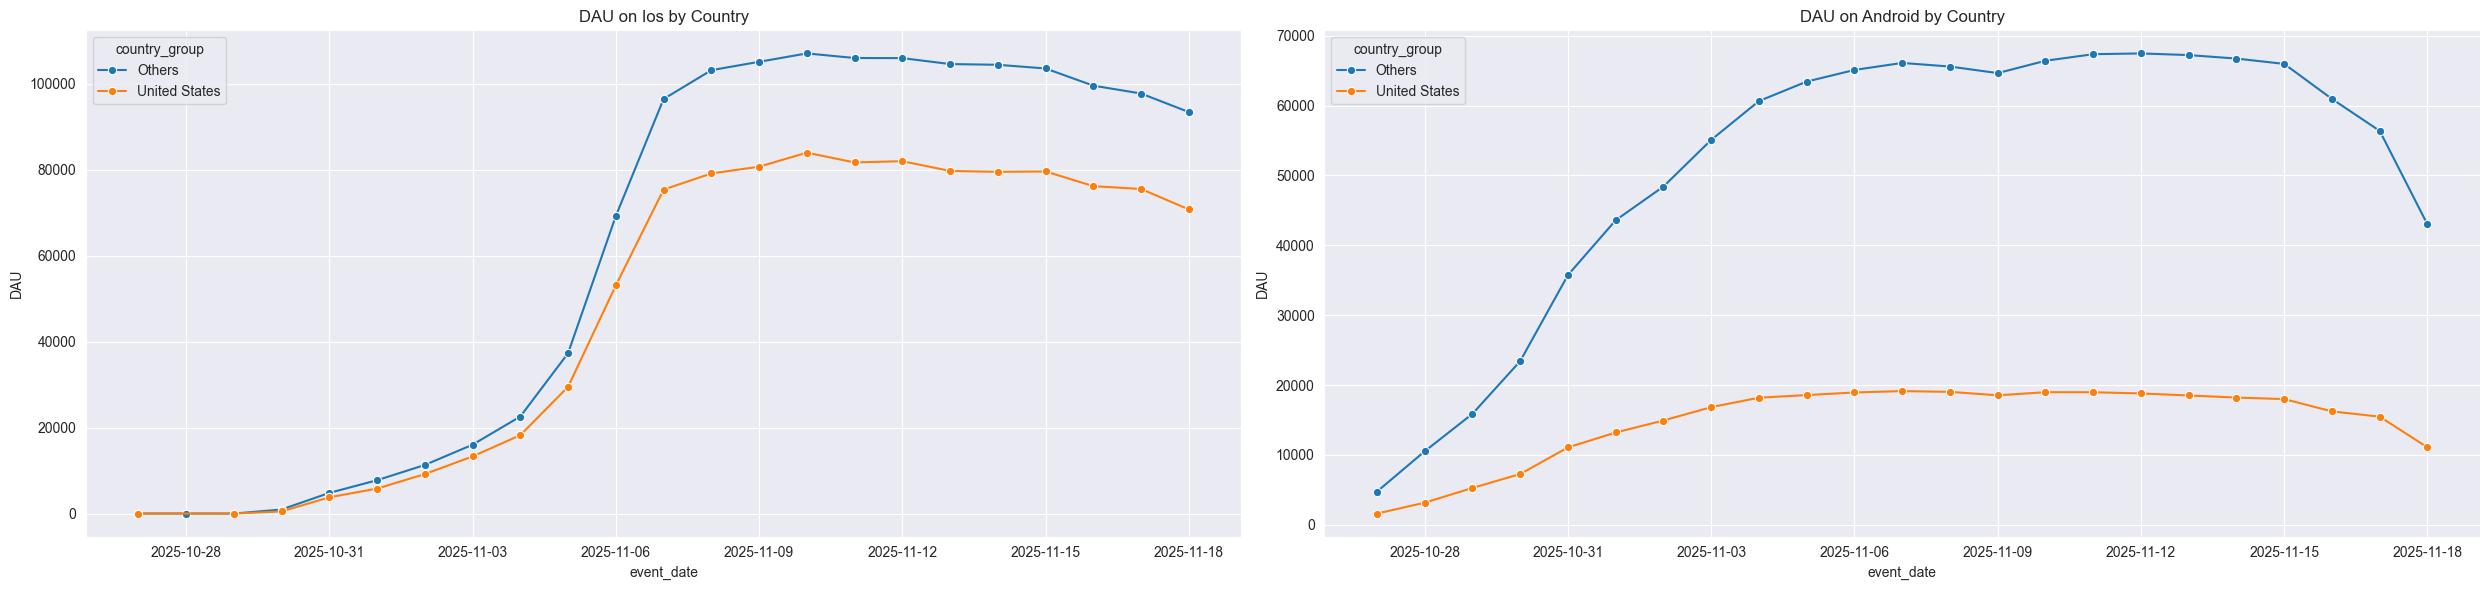

In [14]:
dau_version = active_users[active_users['version'].isin(['1.7.3', '1.7.2'])].groupby(['event_date', 'platform', 'country']).agg(
    dau = ('user_pseudo_id', 'nunique')
).reset_index()
dau_version['country_group'] = dau_version['country'].apply(
    lambda x: 'United States' if x == 'United States' else 'Others'
)
dau_version_grouped = dau_version.groupby(['event_date', 'platform', 'country_group']).agg(
    dau = ('dau', 'sum')
).reset_index()
fig, ax = plt.subplots(1,2, figsize=(25,6))
platform = ['IOS', 'ANDROID']
for i, p in enumerate(platform):
    data = dau_version_grouped[dau_version_grouped['platform'] == p]
    sns.lineplot(data=data, x='event_date', y='dau', hue='country_group', marker='o', ax=ax[i])
    ax[i].set_title(f'DAU on {p.capitalize()} by Country')
    ax[i].set_ylabel('DAU')
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

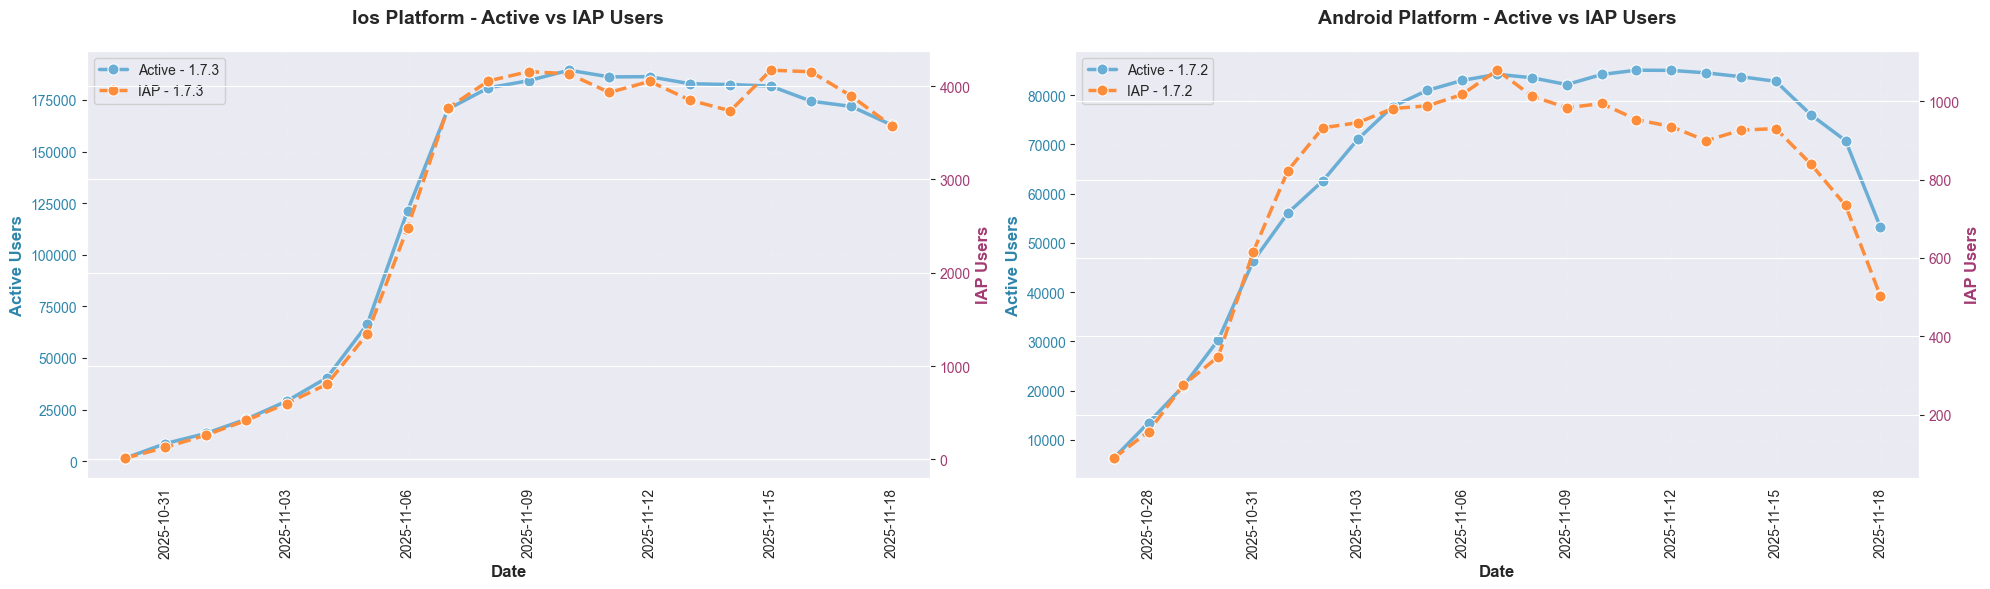

In [15]:
problem_version = pay_rate_platform_version[pay_rate_platform_version['version'].isin(['1.7.3', '1.7.2'])]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
platform = ['IOS', 'ANDROID']
colors = {'active': '#2E86AB', 'iap': '#A23B72'}

for i, p in enumerate(platform):
    data = problem_version[problem_version['platform'] == p]
    ax2 = ax[i].twinx()

    # Plot lines with better styling
    sns.lineplot(data=data, x='event_date', y='active_users', hue='version',
                 marker='o', ax=ax[i], palette='Blues', linewidth=2.5, markersize=8)
    sns.lineplot(data=data, x='event_date', y='iap_users', hue='version',
                 marker='o', ax=ax2, linestyle='--', palette='Oranges', linewidth=2.5, markersize=8)

    # Titles and labels
    ax[i].set_title(f'{p.capitalize()} Platform - Active vs IAP Users', fontsize=14, fontweight='bold', pad=20)
    ax[i].set_xlabel('Date', fontsize=12, fontweight='bold')
    ax[i].set_ylabel('Active Users', fontsize=12, fontweight='bold', color=colors['active'])
    ax2.set_ylabel('IAP Users', fontsize=12, fontweight='bold', color=colors['iap'])

    # Styling
    ax[i].tick_params(axis='y', labelcolor=colors['active'], labelsize=10)
    ax2.tick_params(axis='y', labelcolor=colors['iap'], labelsize=10)
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

    # Combined legend
    lines1, labels1 = ax[i].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax[i].legend(lines1 + lines2, [f'Active - {l}' for l in labels1] + [f'IAP - {l}' for l in labels2],
                 loc='upper left', framealpha=0.9, fontsize=10)
    ax2.get_legend().remove()

plt.tight_layout()
plt.show()

- Ios: Trong giai đoạn từ ngày 07/11 đến ngày 14/11, DAU không biến động nhiều nhưng IAP Users lại giảm mạnh từ ngày 11/11 => Sẽ tách khoảng thời gian 07/11 đến 14/11 để phân tích
- ANDROID: Tổng quan thì thấy Sau ngày 07/11, IAP Users có xu hướng giảm mặc dù DAU không biến động nhiều, tuy nhiên IAP Users lại không giảm mạnh (line gãy) thay vào đó trông có vẻ như sau khi đạt đỉnh thì giảm dần về giai đoạn trước đó hơn

# Phân tích IOS

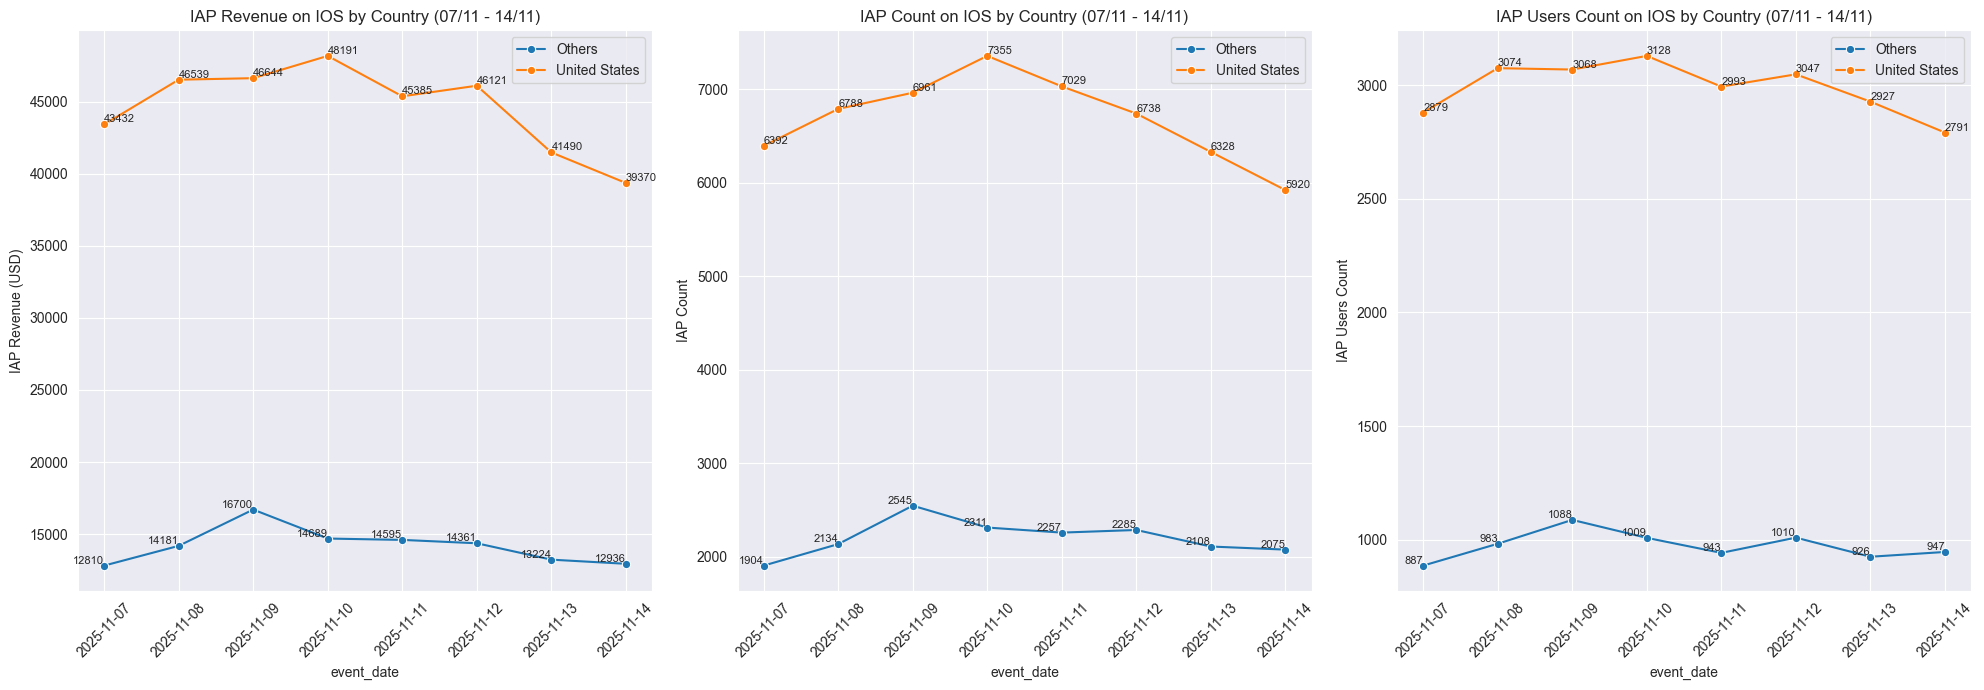

In [16]:
ios_data = iap[(iap['version'].isin(['1.7.3'])) & (iap['event_date'].between(pd.to_datetime('2025-11-07'), pd.to_datetime('2025-11-14')))].groupby(['event_date', 'platform', 'country']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count'),
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()

ios_data['country_group'] = ios_data['country'].apply(
    lambda x: 'United States' if x == 'United States' else 'Others'
)
ios_data_grouped = ios_data.groupby(['event_date', 'platform', 'country_group']).agg(
    iap_revenue = ('iap_revenue', 'sum'),
    iap_count = ('iap_count', 'sum'),
    iap_users = ('iap_users', 'sum')
).reset_index()

fig, ax = plt.subplots(1,3, figsize=(20,7))
data = ios_data_grouped

# Revenue plot
for country in data['country_group'].unique():
    country_data = data[data['country_group'] == country]
    sns.lineplot(data=country_data, x='event_date', y='iap_revenue', label=country, marker='o', ax=ax[0])
    for idx, row in country_data.iterrows():
        ha = 'left' if country == 'United States' else 'right'
        ax[0].text(row['event_date'], row['iap_revenue'], f'{row["iap_revenue"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[0].set_title(f'IAP Revenue on IOS by Country (07/11 - 14/11)')
ax[0].set_ylabel('IAP Revenue (USD)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].tick_params(axis='x', rotation=45)

# Count plot
for country in data['country_group'].unique():
    country_data = data[data['country_group'] == country]
    sns.lineplot(data=country_data, x='event_date', y='iap_count', label=country, marker='o', ax=ax[1])
    for idx, row in country_data.iterrows():
        ha = 'left' if country == 'United States' else 'right'
        ax[1].text(row['event_date'], row['iap_count'], f'{row["iap_count"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[1].set_title(f'IAP Count on IOS by Country (07/11 - 14/11)')
ax[1].set_ylabel('IAP Count')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].tick_params(axis='x', rotation=45)

# IAP Users plot
for country in data['country_group'].unique():
    country_data = data[data['country_group'] == country]
    sns.lineplot(data=country_data, x='event_date', y='iap_users', label=country, marker='o', ax=ax[2])
    for idx, row in country_data.iterrows():
        ha = 'left' if country == 'United States' else 'right'
        ax[2].text(row['event_date'], row['iap_users'], f'{row["iap_users"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[2].set_title(f'IAP Users Count on IOS by Country (07/11 - 14/11)')
ax[2].set_ylabel('IAP Users Count')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Như vậy trong khoảng thời gian này, IAP revenue giảm chủ yếu do US giảm mạnh cả về revenue, iap count và iap users, trong khi đó các nước khác không biến động mạnh => Cần tách riêng US để đánh giá, trong khoảng tgian này bị giảm do tệp users nào? Mới hay cũ?

In [31]:
ios_iap_data = """
SELECT s1.* EXCEPT(ga_session_id, ga_session_number, price, currency, quantity, value), s2.event_date AS login_date
FROM `wool-away.knit_away_flatten.in_app_purchase` s1
LEFT JOIN `wool-away.knit_away_flatten.first_open` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s1.event_date >= s2.event_date
WHERE s1.version = '1.7.3'
    AND s1.event_date BETWEEN '2025-11-07' AND '2025-11-14'
    AND s1.platform = 'IOS'
    AND s1.country = 'United States'
QUALIFY ROW_NUMBER() OVER (PARTITION BY s2.user_pseudo_id ORDER BY s2.event_date DESC) = 1
"""
ios_iap_data = client.query(ios_iap_data).to_dataframe()

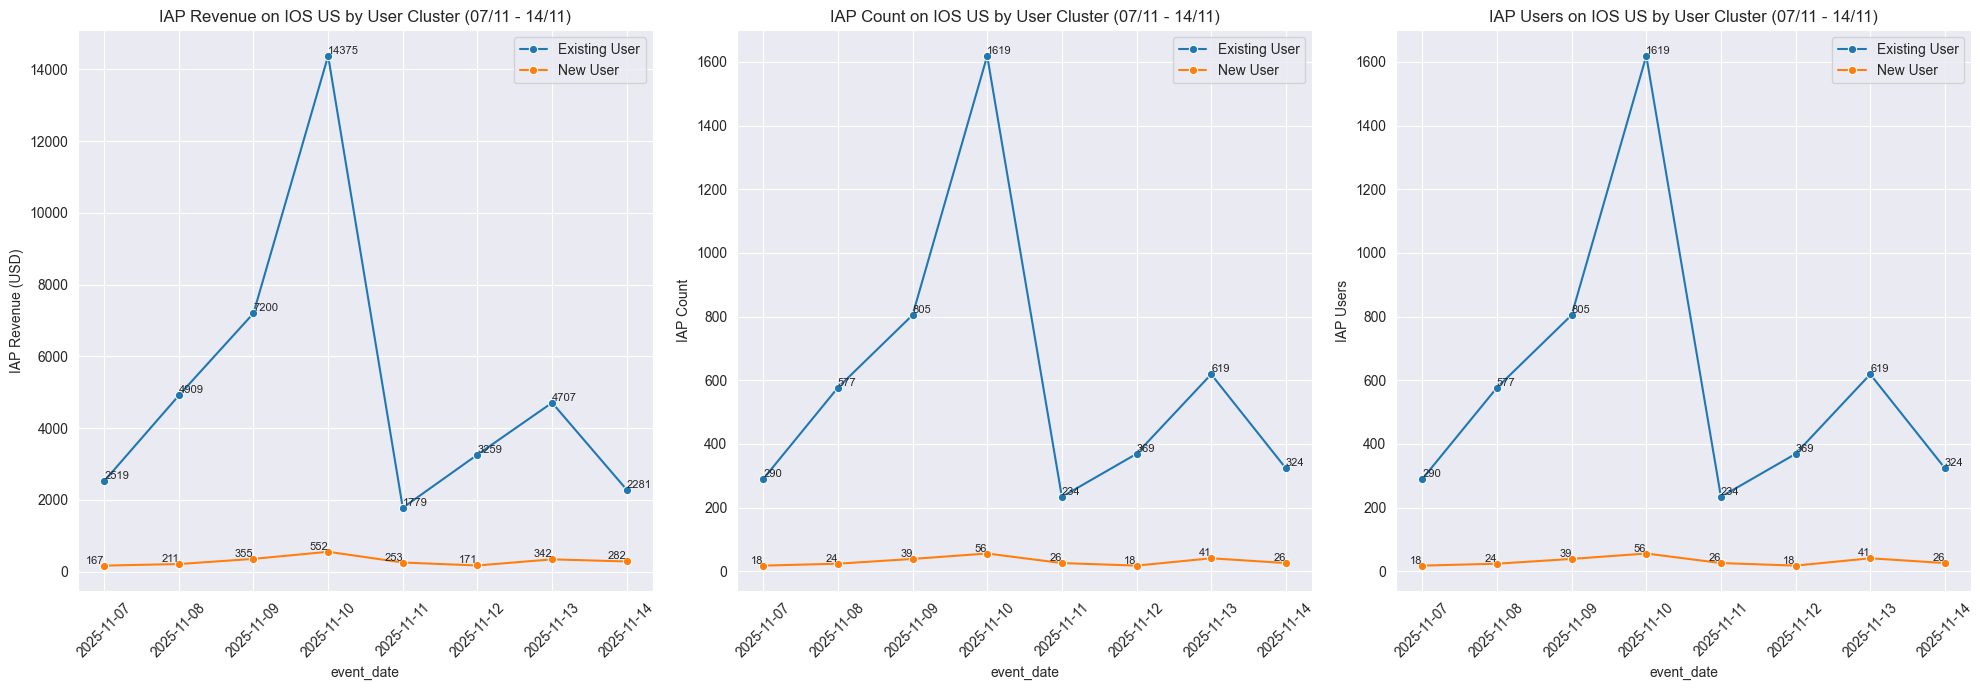

In [18]:
ios_iap_data['user_cluster'] = np.where(
    ios_iap_data['login_date'] < ios_iap_data['event_date'],
    'Existing User',
    'New User')

ios_iap_data_agg = ios_iap_data.groupby(['event_date', 'user_cluster']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count'),
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()

fig, ax = plt.subplots(1,3, figsize=(20,7))

# Revenue plot
for cluster in ios_iap_data_agg['user_cluster'].unique():
    cluster_data = ios_iap_data_agg[ios_iap_data_agg['user_cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='event_date', y='iap_revenue', label=cluster, marker='o', ax=ax[0])
    for idx, row in cluster_data.iterrows():
        ha = 'left' if cluster == 'Existing User' else 'right'
        ax[0].text(row['event_date'], row['iap_revenue'], f'{row["iap_revenue"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[0].set_title(f'IAP Revenue on IOS US by User Cluster (07/11 - 14/11)')
ax[0].set_ylabel('IAP Revenue (USD)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].tick_params(axis='x', rotation=45)

# Count plot
for cluster in ios_iap_data_agg['user_cluster'].unique():
    cluster_data = ios_iap_data_agg[ios_iap_data_agg['user_cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='event_date', y='iap_count', label=cluster, marker='o', ax=ax[1])
    for idx, row in cluster_data.iterrows():
        ha = 'left' if cluster == 'Existing User' else 'right'
        ax[1].text(row['event_date'], row['iap_count'], f'{row["iap_count"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[1].set_title(f'IAP Count on IOS US by User Cluster (07/11 - 14/11)')
ax[1].set_ylabel('IAP Count')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].tick_params(axis='x', rotation=45)

# Users plot
for cluster in ios_iap_data_agg['user_cluster'].unique():
    cluster_data = ios_iap_data_agg[ios_iap_data_agg['user_cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='event_date', y='iap_users', label=cluster, marker='o', ax=ax[2])
    for idx, row in cluster_data.iterrows():
        ha = 'left' if cluster == 'Existing User' else 'right'
        ax[2].text(row['event_date'], row['iap_users'], f'{row["iap_users"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[2].set_title(f'IAP Users on IOS US by User Cluster (07/11 - 14/11)')
ax[2].set_ylabel('IAP Users')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Giảm mạnh là do nhóm users cũ (Existing Users) => Có phải do trước đó họ mua nhiều rồi nên giờ không mua nữa?
- Tuy nhiên cũng cần xem pay_rate theo cohort của các nhóm users mới trong khoảng tgian này để biết là do users lâu rồi hay là do users mới này mua ít

In [28]:
ios_new_users = """
SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS new_users
FROM `wool-away.knit_away_flatten.first_open` s1
WHERE s1.event_date BETWEEN '2025-11-07' AND '2025-11-14'
    AND s1.version = '1.7.3'
    AND s1.country = 'United States'
GROUP BY event_date
"""
ios_new_users = client.query(ios_new_users).to_dataframe()

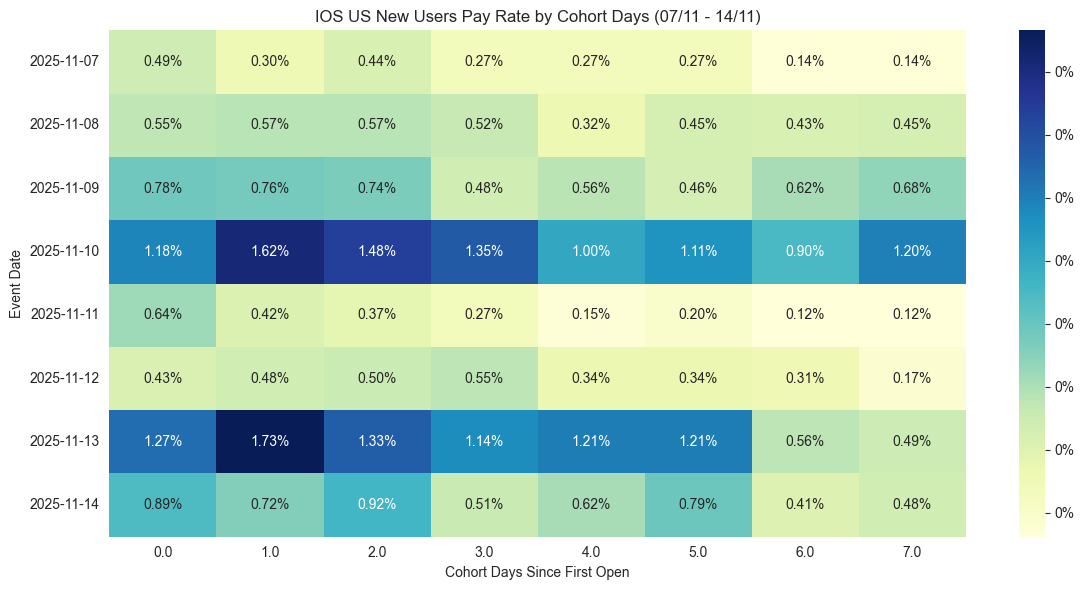

In [32]:
ios_iap_data['cohort_days'] = (pd.to_datetime(ios_iap_data['event_date']) - pd.to_datetime(ios_iap_data['login_date'])).dt.days
ios_iap_cohort = ios_iap_data.groupby(['event_date', 'cohort_days']).agg(
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()
ios_iap_cohort = pd.merge(ios_iap_cohort, ios_new_users, on='event_date', how='left')
ios_iap_cohort['pay_rate'] = ios_iap_cohort['iap_users'] / ios_iap_cohort['new_users']

ios_iap_unpivot = ios_iap_cohort[ios_iap_cohort['cohort_days'] <= 7].pivot(index='event_date', columns='cohort_days', values='pay_rate')
ios_iap_unpivot = ios_iap_unpivot.fillna(0)
ios_iap_unpivot = ios_iap_unpivot.astype(float)  # Ensure all values are float

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(ios_iap_unpivot, annot=True, fmt=".2%", cmap='YlGnBu', ax=ax, cbar_kws={'format': '%.0f%%'})
ax.set_title('IOS US New Users Pay Rate by Cohort Days (07/11 - 14/11)')
ax.set_ylabel('Event Date')
ax.set_xlabel('Cohort Days Since First Open')
plt.tight_layout()
plt.show()

- Như vậy là nhóm users mới không làm giảm pay rate, nguyên nhân chính dẫn tới giảm pay rate là do nhóm users cũ (Existing Users) mua ít đi. Nhóm first open từ 11/11 về sau có pay rate khá ổn tại các D sau nên việc giảm pay rate không phải do nhóm users mới
- Với tệp Users cũ, sẽ chia thành 2 nhóm login trước 1/11 và sau 1/11 để đánh giá tiếp

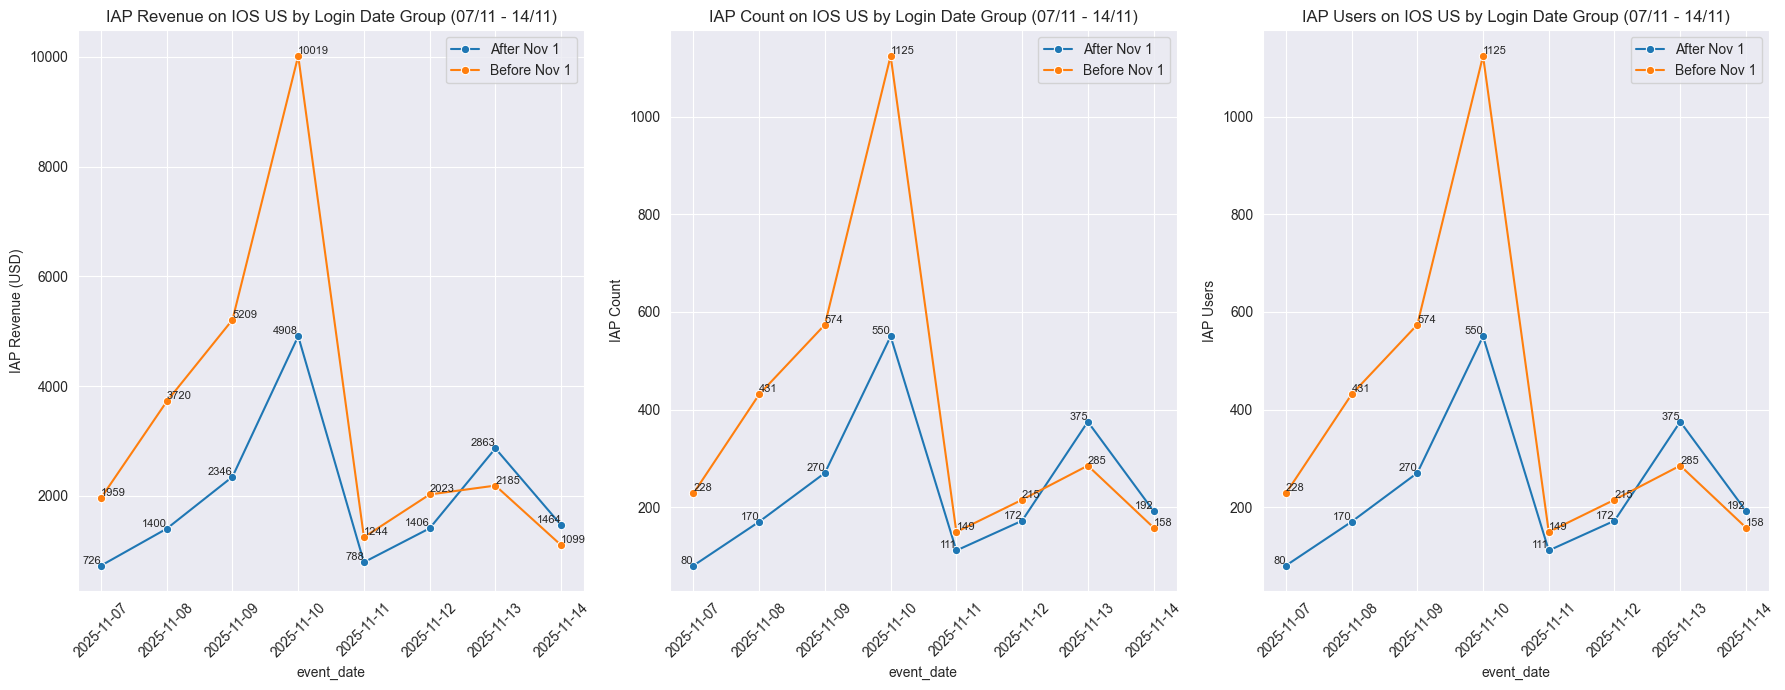

In [34]:
ios_iap_data['login_date_group'] = np.where(
    ios_iap_data['login_date'] < pd.to_datetime('2025-11-01'),
    'Before Nov 1',
    'After Nov 1'
)
ios_iap_login_group = ios_iap_data.groupby(['event_date', 'login_date_group']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count'),
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()

fig, ax = plt.subplots(1,3, figsize=(18,7))
# Revenue plot
for group in ios_iap_login_group['login_date_group'].unique():
    group_data = ios_iap_login_group[ios_iap_login_group['login_date_group'] == group]
    sns.lineplot(data=group_data, x='event_date', y='iap_revenue', label=group, marker='o', ax=ax[0])
    for idx, row in group_data.iterrows():
        ha = 'left' if group == 'Before Nov 1' else 'right'
        ax[0].text(row['event_date'], row['iap_revenue'], f'{row["iap_revenue"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')
ax[0].set_title(f'IAP Revenue on IOS US by Login Date Group (07/11 - 14/11)')
ax[0].set_ylabel('IAP Revenue (USD)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].tick_params(axis='x', rotation=45)
# Count plot
for group in ios_iap_login_group['login_date_group'].unique():
    group_data = ios_iap_login_group[ios_iap_login_group['login_date_group'] == group]
    sns.lineplot(data=group_data, x='event_date', y='iap_count', label=group, marker='o', ax=ax[1])
    for idx, row in group_data.iterrows():
        ha = 'left' if group == 'Before Nov 1' else 'right'
        ax[1].text(row['event_date'], row['iap_count'], f'{row["iap_count"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')
ax[1].set_title(f'IAP Count on IOS US by Login Date Group (07/11 - 14/11)')
ax[1].set_ylabel('IAP Count')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].tick_params(axis='x', rotation=45)
# Users plot
for group in ios_iap_login_group['login_date_group'].unique():
    group_data = ios_iap_login_group[ios_iap_login_group['login_date_group'] == group]
    sns.lineplot(data=group_data, x='event_date', y='iap_users', label=group, marker='o', ax=ax[2])
    for idx, row in group_data.iterrows():
        ha = 'left' if group == 'Before Nov 1' else 'right'
        ax[2].text(row['event_date'], row['iap_users'], f'{row["iap_users"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')
ax[2].set_title(f'IAP Users on IOS US by Login Date Group (07/11 - 14/11)')
ax[2].set_ylabel('IAP Users')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Qua chart này thì thấy rằng nếu theo logic, với nhóm users cũ login trước 1/11 thì day by day phải giảm dần, tuy nhiên thực tế thì trước ngày 10/11 đều tăng, nhưng sau đó giảm mạnh => Có vấn đề gì đó? Hay là crash game? => Sẽ xem thử là trước đó users mua gói gì

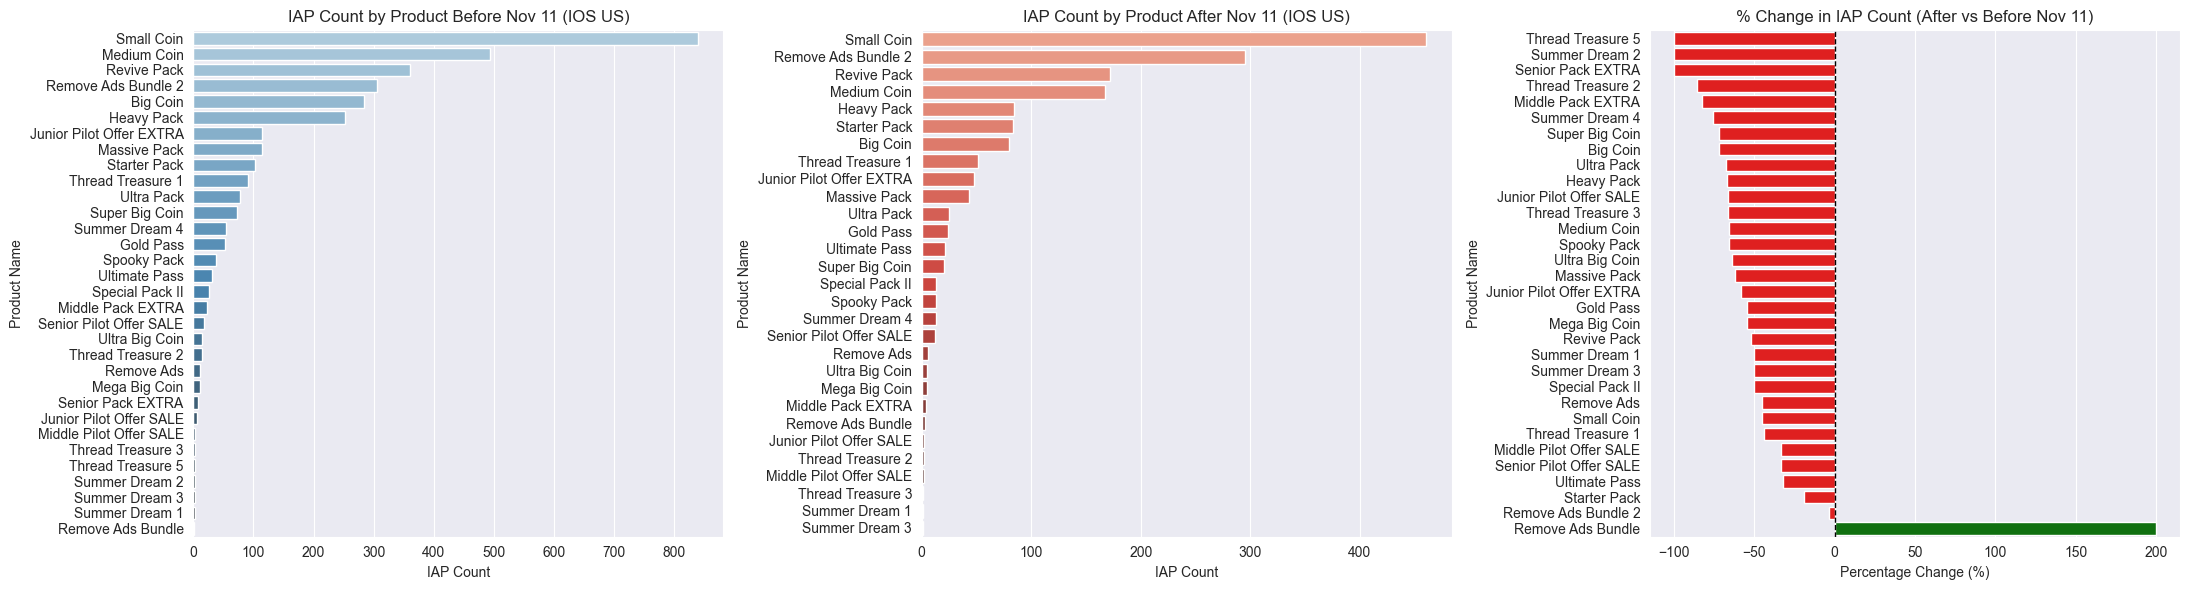

In [22]:
product_list = iap.groupby('product_id')['product_name'].first().reset_index().to_dict(orient='records')
ios_iap_data['product_name'] = ios_iap_data['product_id'].map(
    {item['product_id']: item['product_name'] for item in product_list}
)
before_data = ios_iap_data[ios_iap_data['event_date'] <= pd.to_datetime('2025-11-10')].groupby('product_name').agg(
    iap_count = ('event_timestamp', 'count'),
    avg_price = ('event_value_in_usd', 'mean')
).reset_index().sort_values('iap_count', ascending=False)

after_data = ios_iap_data[ios_iap_data['event_date'] >= pd.to_datetime('2025-11-11')].groupby('product_name').agg(
    iap_count = ('event_timestamp', 'count'),
    avg_price = ('event_value_in_usd', 'mean')
).reset_index().sort_values('iap_count', ascending=False)

# Calculate percentage change
comparison = pd.merge(before_data, after_data, on='product_name', how='outer', suffixes=('_before', '_after'))
comparison = comparison.fillna(0)
comparison['pct_change'] = ((comparison['iap_count_after'] - comparison['iap_count_before']) / comparison['iap_count_before'].replace(0, np.nan)) * 100
comparison = comparison.sort_values('pct_change', ascending=True)  # Changed to ascending=True

fig, ax = plt.subplots(1,3, figsize=(22,6))
sns.barplot(data=before_data, x='iap_count', y='product_name', hue='product_name', ax=ax[0], palette='Blues_d', legend=False)
ax[0].set_title('IAP Count by Product Before Nov 11 (IOS US)')
ax[0].set_xlabel('IAP Count')
ax[0].set_ylabel('Product Name')

sns.barplot(data=after_data, x='iap_count', y='product_name', hue='product_name', ax=ax[1], palette='Reds_d', legend=False)
ax[1].set_title('IAP Count by Product After Nov 11 (IOS US)')
ax[1].set_xlabel('IAP Count')
ax[1].set_ylabel('Product Name')

# Percentage change chart with conditional colors
colors = ['green' if x > 0 else 'red' for x in comparison['pct_change']]
sns.barplot(data=comparison, x='pct_change', y='product_name', hue='product_name', ax=ax[2], palette=colors, legend=False)
ax[2].set_title('% Change in IAP Count (After vs Before Nov 11)')
ax[2].set_xlabel('Percentage Change (%)')
ax[2].set_ylabel('Product Name')
ax[2].axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

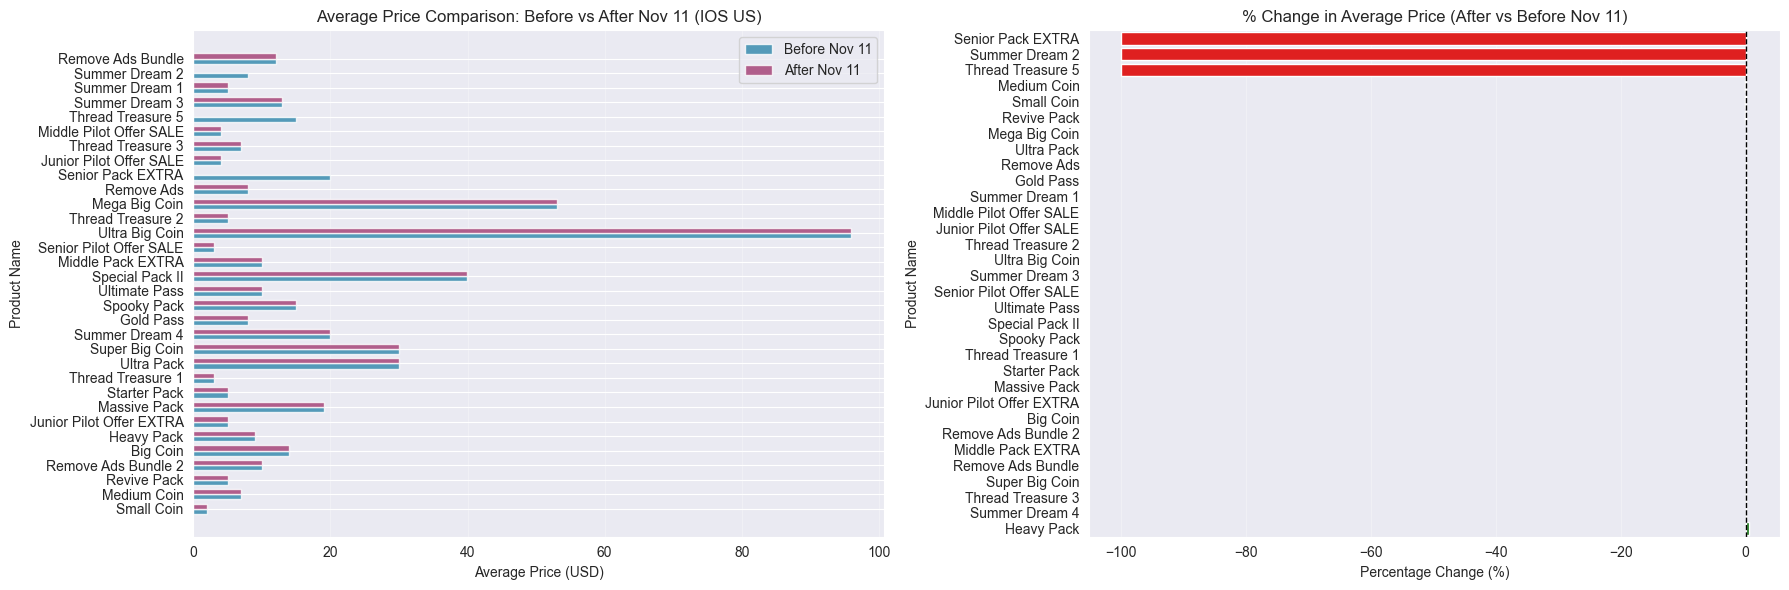

In [23]:
# Average price comparison
comparison_price = comparison.sort_values('iap_count_before', ascending=False)
comparison_price = comparison_price[comparison_price['iap_count_before'] > 0]

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Before vs After average price
x_pos = np.arange(len(comparison_price))
width = 0.35

bars1 = ax[0].barh(x_pos - width/2, comparison_price['avg_price_before'], width, label='Before Nov 11', color='#2E86AB', alpha=0.8)
bars2 = ax[0].barh(x_pos + width/2, comparison_price['avg_price_after'], width, label='After Nov 11', color='#A23B72', alpha=0.8)

ax[0].set_yticks(x_pos)
ax[0].set_yticklabels(comparison_price['product_name'])
ax[0].set_xlabel('Average Price (USD)')
ax[0].set_ylabel('Product Name')
ax[0].set_title('Average Price Comparison: Before vs After Nov 11 (IOS US)')
ax[0].legend()
ax[0].grid(axis='x', alpha=0.3)

# Percentage change in average price
comparison_price['price_pct_change'] = ((comparison_price['avg_price_after'] - comparison_price['avg_price_before']) / comparison_price['avg_price_before'].replace(0, np.nan)) * 100
comparison_price_sorted = comparison_price.sort_values('price_pct_change', ascending=True)

colors_price = ['green' if x > 0 else 'red' for x in comparison_price_sorted['price_pct_change']]
sns.barplot(data=comparison_price_sorted, x='price_pct_change', y='product_name', hue='product_name', ax=ax[1], palette=colors_price, legend=False)
ax[1].set_title('% Change in Average Price (After vs Before Nov 11)')
ax[1].set_xlabel('Percentage Change (%)')
ax[1].set_ylabel('Product Name')
ax[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
ax[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Không có sự thay đổi về giá

In [5]:
iap_show = """
SELECT
    event_date,
    pack_name,
    version,
    COUNT(event_timestamp) AS total_show
FROM `wool-away.dev_staging.stg_iap_show`
WHERE 1=1
    AND version IN ('1.7.3', '1.7.2')
    AND event_date >= '2025-11-01'
    AND country = 'United State'
GROUP BY ALL
"""
iap_show = client.query(iap_show).to_dataframe()

In [ ]:
iap_show_exp = (
    iap_show.assign(pack_name=iap_show['pack_name'].str.split(r'\s*,\s*'))
      .explode('pack_name')
      .dropna(subset=['pack_name'])
      .reset_index(drop=True)
)
iap_show_exp['pack_name'] = iap_show_exp['pack_name'].replace(r'^\s*$', np.nan, regex=True)
iap_show_exp = iap_show_exp.dropna(subset=['pack_name']).reset_index(drop=True)

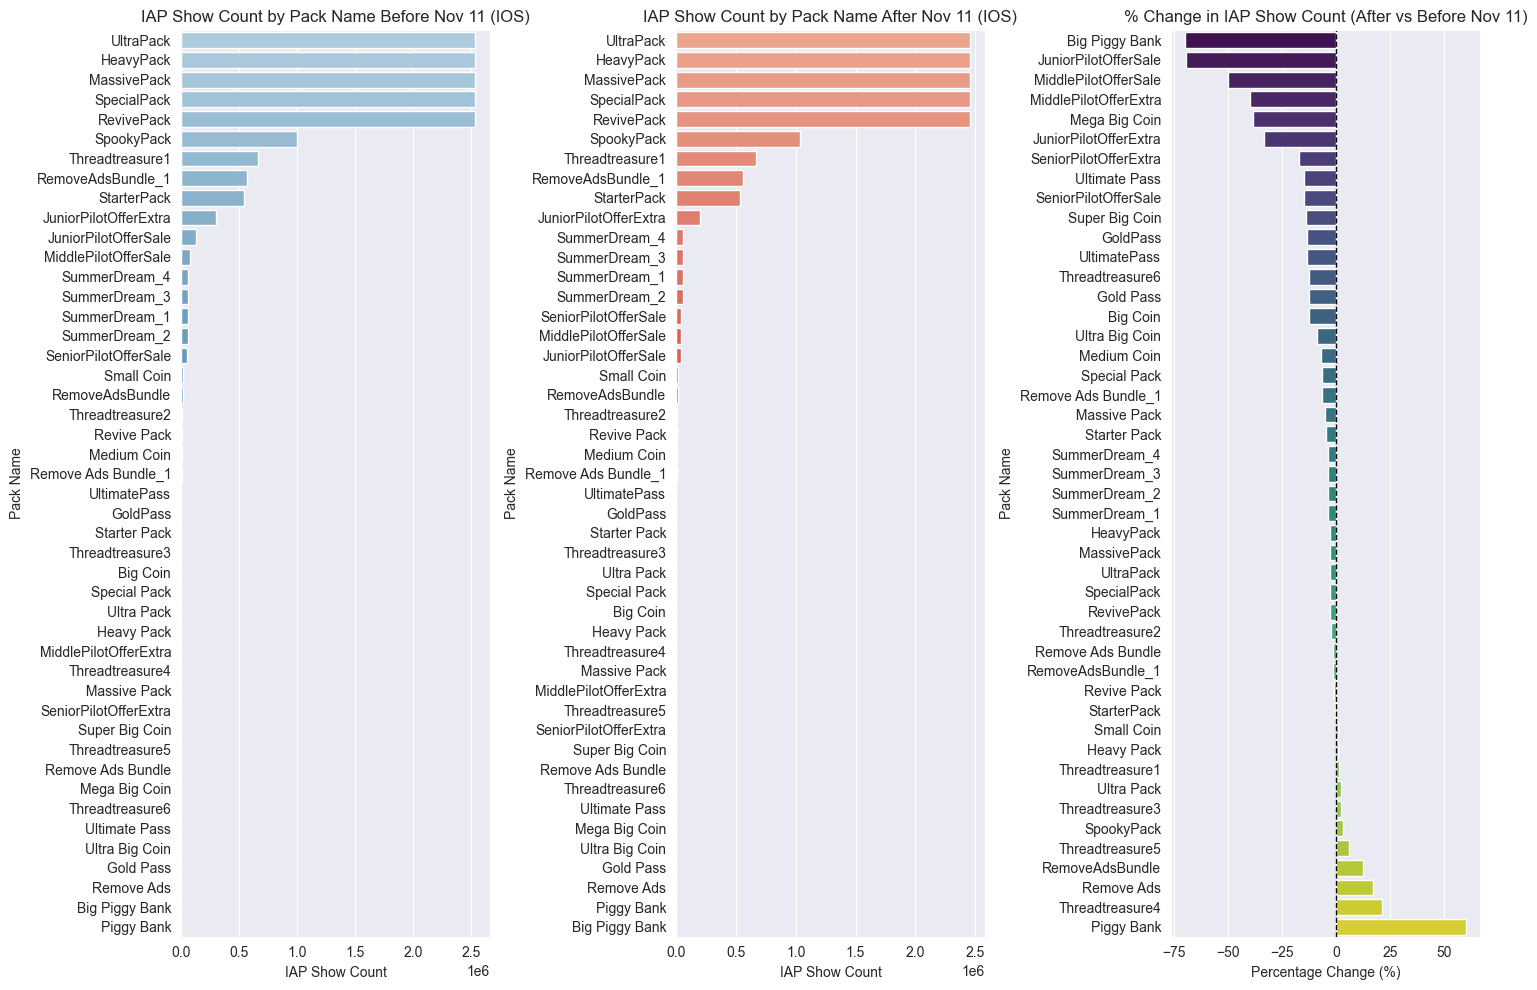

In [13]:
ios_iap_show = iap_show_exp[
    (iap_show_exp['event_date'].between(pd.to_datetime('2025-11-07'), pd.to_datetime('2025-11-14'))) &
    (iap_show_exp['version'] == '1.7.3')
]
ios_iap_show_before = ios_iap_show[ios_iap_show['event_date'] <= pd.to_datetime('2025-11-10')].groupby('pack_name').agg(
    show_count = ('total_show', 'sum')
).reset_index().sort_values('show_count', ascending=False)
ios_iap_show_after = ios_iap_show[ios_iap_show['event_date'] >= pd.to_datetime('2025-11-11')].groupby('pack_name').agg(
    show_count = ('total_show', 'sum')
).reset_index().sort_values('show_count', ascending=False)

fig, ax = plt.subplots(1,3, figsize=(15,10))
sns.barplot(data=ios_iap_show_before, x='show_count', y='pack_name', hue='pack_name', ax=ax[0], palette='Blues_d', legend=False)
ax[0].set_title('IAP Show Count by Pack Name Before Nov 11 (IOS)')
ax[0].set_xlabel('IAP Show Count')
ax[0].set_ylabel('Pack Name')
sns.barplot(data=ios_iap_show_after, x='show_count', y='pack_name', hue='pack_name', ax=ax[1], palette='Reds_d', legend=False)
ax[1].set_title('IAP Show Count by Pack Name After Nov 11 (IOS)')
ax[1].set_xlabel('IAP Show Count')
ax[1].set_ylabel('Pack Name')
# Percentage change
comparison_show = pd.merge(ios_iap_show_before, ios_iap_show_after, on='pack_name', how='outer', suffixes=('_before', '_after'))
comparison_show = comparison_show.fillna(0)
comparison_show['pct_change'] = ((comparison_show['show_count_after'] - comparison_show['show_count_before']) / comparison_show['show_count_before'].replace(0, np.nan)) * 100
comparison_show = comparison_show.sort_values('pct_change', ascending=True)
sns.barplot(data=comparison_show, x='pct_change', y='pack_name', hue='pack_name', ax=ax[2], palette='viridis', legend=False)
ax[2].set_title('% Change in IAP Show Count (After vs Before Nov 11)')
ax[2].set_xlabel('Percentage Change (%)')
ax[2].set_ylabel('Pack Name')
ax[2].axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

Không phải do lỗi lượt show

In [20]:
user_play_time = """
SELECT
    event_date,
    version,
    (AVG(engagement_time_msec) / 60000) AS avg_play_time_minutes
FROM `wool-away.dev_staging.stg_user_engagement_agg`
WHERE event_date >= '2025-11-01'
    AND version IN ('1.7.2', '1.7.3')
GROUP BY event_date, version
"""
user_play_time = client.query(user_play_time).to_dataframe()

In [23]:
ios_user_play_time = user_play_time[user_play_time['version'] == '1.7.3']

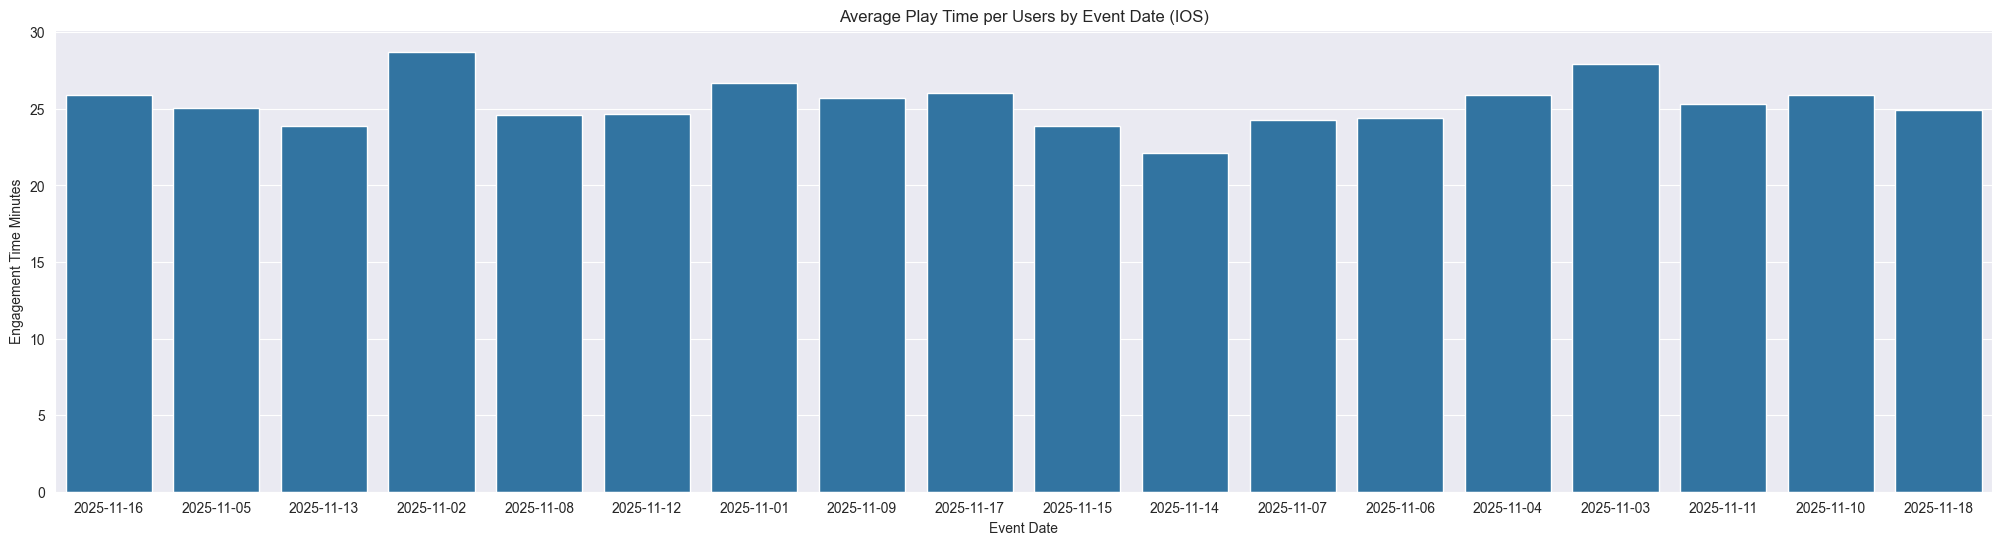

In [26]:
fig, ax = plt.subplots(figsize=(25,6))
sns.barplot(data=ios_user_play_time, x='event_date', y='avg_play_time_minutes')
ax.set_title('Average Play Time per Users by Event Date (IOS)')
ax.set_xlabel('Event Date')
ax.set_ylabel('Engagement Time Minutes')
plt.show()

# Phân tích ANDROID

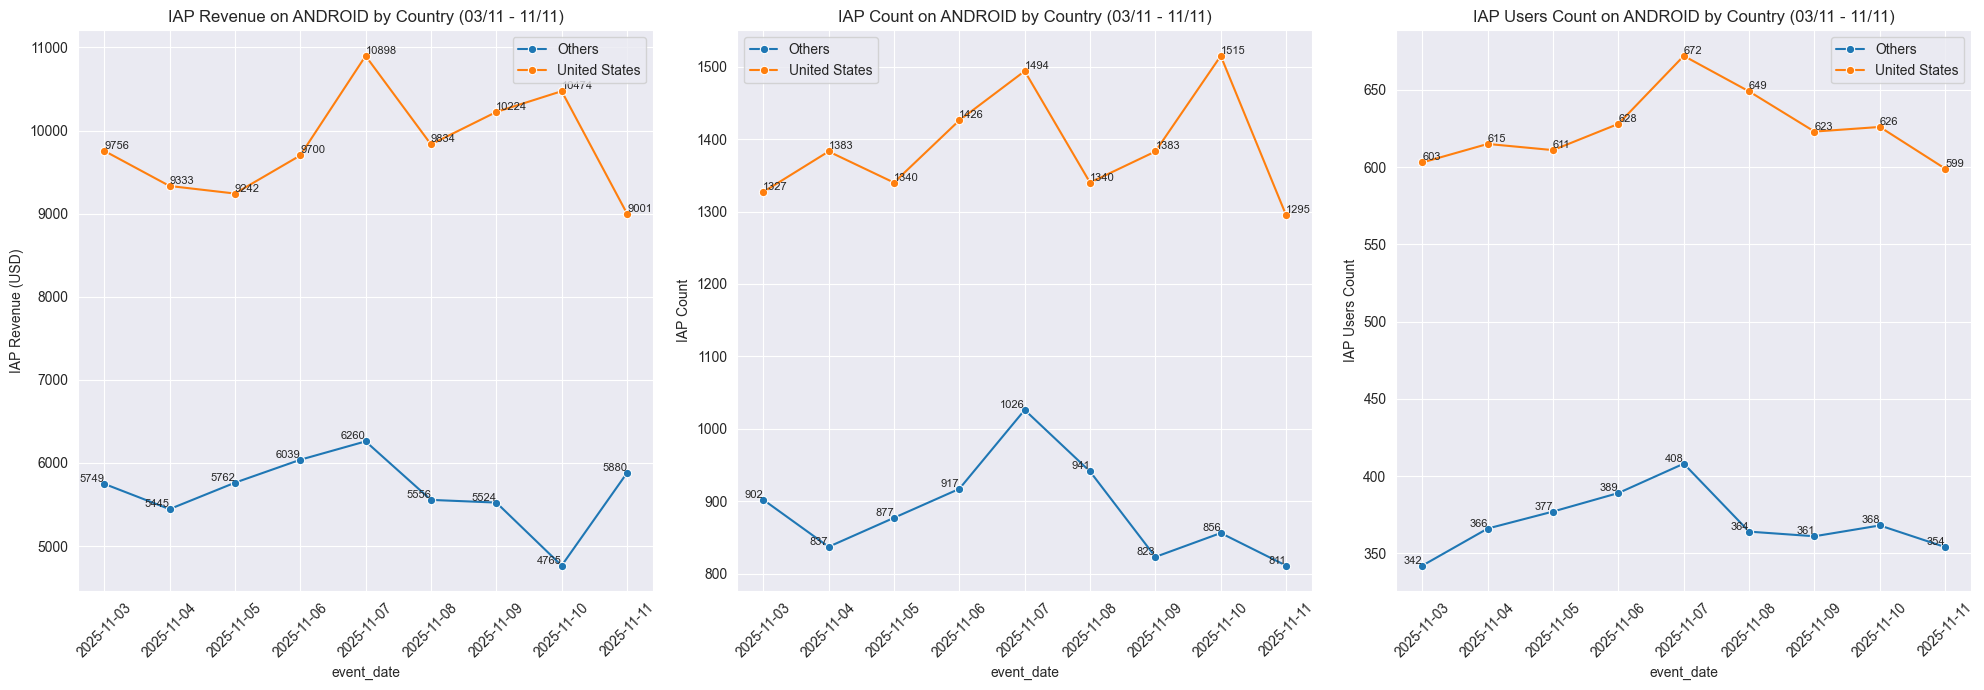

In [40]:
android_data = iap[(iap['version'].isin(['1.7.2'])) & (iap['event_date'].between(pd.to_datetime('2025-11-03'), pd.to_datetime('2025-11-11')))].groupby(['event_date', 'platform', 'country']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count'),
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()

android_data['country_group'] = android_data['country'].apply(
    lambda x: 'United States' if x == 'United States' else 'Others'
)
android_data_grouped = android_data.groupby(['event_date', 'platform', 'country_group']).agg(
    iap_revenue = ('iap_revenue', 'sum'),
    iap_count = ('iap_count', 'sum'),
    iap_users = ('iap_users', 'sum')
).reset_index()

fig, ax = plt.subplots(1,3, figsize=(20,7))
data = android_data_grouped

# Revenue plot
for country in data['country_group'].unique():
    country_data = data[data['country_group'] == country]
    sns.lineplot(data=country_data, x='event_date', y='iap_revenue', label=country, marker='o', ax=ax[0])
    for idx, row in country_data.iterrows():
        ha = 'left' if country == 'United States' else 'right'
        ax[0].text(row['event_date'], row['iap_revenue'], f'{row["iap_revenue"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[0].set_title(f'IAP Revenue on ANDROID by Country (03/11 - 11/11)')
ax[0].set_ylabel('IAP Revenue (USD)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].tick_params(axis='x', rotation=45)

# Count plot
for country in data['country_group'].unique():
    country_data = data[data['country_group'] == country]
    sns.lineplot(data=country_data, x='event_date', y='iap_count', label=country, marker='o', ax=ax[1])
    for idx, row in country_data.iterrows():
        ha = 'left' if country == 'United States' else 'right'
        ax[1].text(row['event_date'], row['iap_count'], f'{row["iap_count"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[1].set_title(f'IAP Count on ANDROID by Country (03/11 - 11/11)')
ax[1].set_ylabel('IAP Count')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].tick_params(axis='x', rotation=45)

# IAP Users plot
for country in data['country_group'].unique():
    country_data = data[data['country_group'] == country]
    sns.lineplot(data=country_data, x='event_date', y='iap_users', label=country, marker='o', ax=ax[2])
    for idx, row in country_data.iterrows():
        ha = 'left' if country == 'United States' else 'right'
        ax[2].text(row['event_date'], row['iap_users'], f'{row["iap_users"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[2].set_title(f'IAP Users Count on ANDROID by Country (03/11 - 11/11)')
ax[2].set_ylabel('IAP Users Count')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Như vậy trong khoảng thời gian này, IAP revenue giảm chủ yếu do các quốc gia khác giảm mạnh cả về revenue, iap count và iap users, trong khi đó US không biến động mạnh => Cần tách riêng các quốc gia ngoài US để đánh giá, trong khoảng tgian này bị giảm do tệp users nào? Mới hay cũ?

In [43]:
and_iap_data = """
SELECT s1.* EXCEPT(ga_session_id, ga_session_number, price, currency, quantity, value), s2.event_date AS login_date
FROM `wool-away.knit_away_flatten.in_app_purchase` s1
LEFT JOIN `wool-away.knit_away_flatten.first_open` s2
    ON s1.user_pseudo_id = s2.user_pseudo_id
    AND s1.event_date >= s2.event_date
WHERE s1.version = '1.7.2'
    AND s1.event_date BETWEEN '2025-11-03' AND '2025-11-11'
    AND s1.country != 'United States'
QUALIFY ROW_NUMBER() OVER (PARTITION BY s2.user_pseudo_id ORDER BY s2.event_date DESC) = 1
"""
and_iap_data = client.query(and_iap_data).to_dataframe()

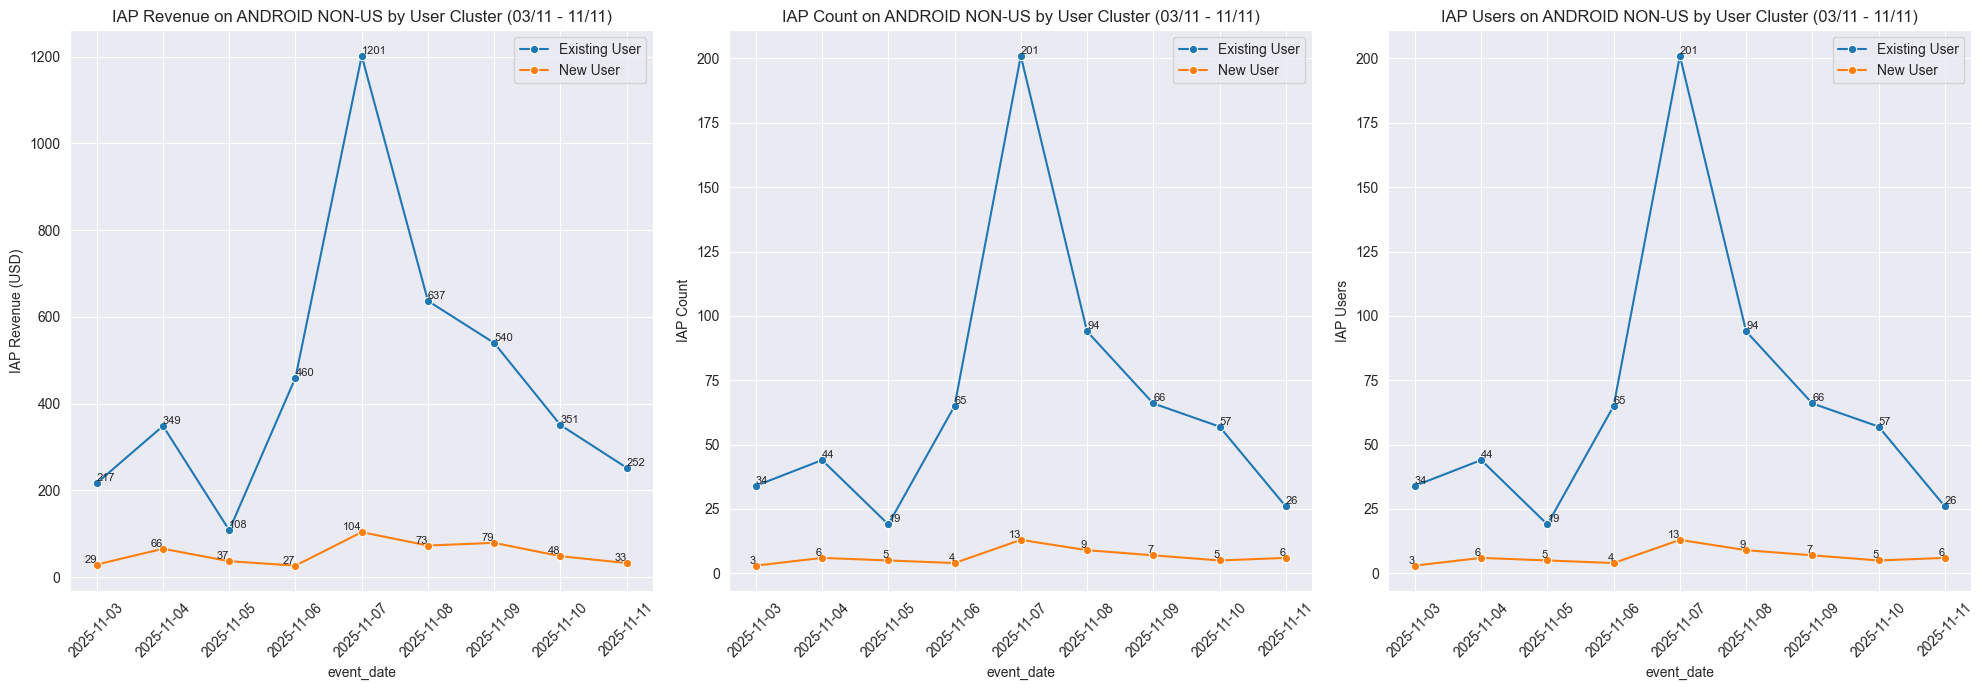

In [46]:
and_iap_data['user_cluster'] = np.where(
    and_iap_data['login_date'] < and_iap_data['event_date'],
    'Existing User',
    'New User')

and_iap_data_agg = and_iap_data.groupby(['event_date', 'user_cluster']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count'),
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()

fig, ax = plt.subplots(1,3, figsize=(20,7))

# Revenue plot
for cluster in and_iap_data_agg['user_cluster'].unique():
    cluster_data = and_iap_data_agg[and_iap_data_agg['user_cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='event_date', y='iap_revenue', label=cluster, marker='o', ax=ax[0])
    for idx, row in cluster_data.iterrows():
        ha = 'left' if cluster == 'Existing User' else 'right'
        ax[0].text(row['event_date'], row['iap_revenue'], f'{row["iap_revenue"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[0].set_title(f'IAP Revenue on ANDROID NON-US by User Cluster (03/11 - 11/11)')
ax[0].set_ylabel('IAP Revenue (USD)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].tick_params(axis='x', rotation=45)

# Count plot
for cluster in and_iap_data_agg['user_cluster'].unique():
    cluster_data = and_iap_data_agg[and_iap_data_agg['user_cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='event_date', y='iap_count', label=cluster, marker='o', ax=ax[1])
    for idx, row in cluster_data.iterrows():
        ha = 'left' if cluster == 'Existing User' else 'right'
        ax[1].text(row['event_date'], row['iap_count'], f'{row["iap_count"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[1].set_title(f'IAP Count on ANDROID NON-US by User Cluster (03/11 - 11/11)')
ax[1].set_ylabel('IAP Count')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].tick_params(axis='x', rotation=45)

# Users plot
for cluster in and_iap_data_agg['user_cluster'].unique():
    cluster_data = and_iap_data_agg[and_iap_data_agg['user_cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='event_date', y='iap_users', label=cluster, marker='o', ax=ax[2])
    for idx, row in cluster_data.iterrows():
        ha = 'left' if cluster == 'Existing User' else 'right'
        ax[2].text(row['event_date'], row['iap_users'], f'{row["iap_users"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')

ax[2].set_title(f'IAP Users on ANDROID NON-US by User Cluster (03/11 - 11/11)')
ax[2].set_ylabel('IAP Users')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

- Giảm mạnh là do nhóm users cũ (Existing Users) => Có phải do trước đó họ mua nhiều rồi nên giờ không mua nữa?
- Tuy nhiên cũng cần xem pay_rate theo cohort của các nhóm users mới trong khoảng tgian này để biết là do users lâu rồi hay là do users mới này mua ít

In [45]:
and_new_users = """
SELECT
    event_date,
    COUNT(DISTINCT user_pseudo_id) AS new_users
FROM `wool-away.knit_away_flatten.first_open` s1
WHERE s1.event_date BETWEEN '2025-11-03' AND '2025-11-11'
    AND s1.version = '1.7.2'
    AND s1.country != 'United States'
GROUP BY event_date
"""
and_new_users = client.query(and_new_users).to_dataframe()

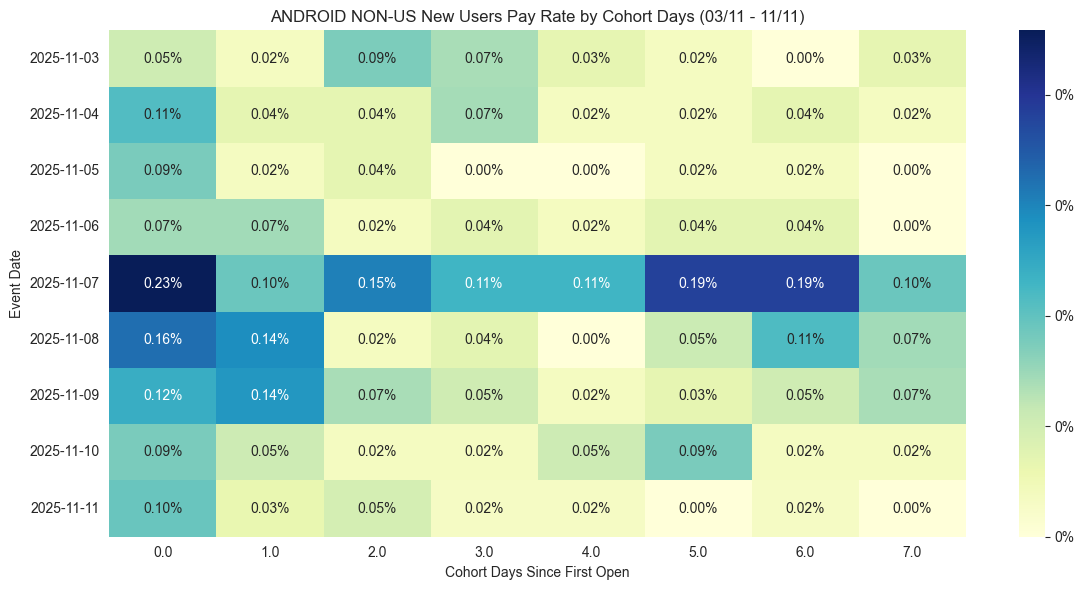

In [48]:
and_iap_data['cohort_days'] = (pd.to_datetime(and_iap_data['event_date']) - pd.to_datetime(and_iap_data['login_date'])).dt.days
and_iap_cohort = and_iap_data.groupby(['event_date', 'cohort_days']).agg(
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()
and_iap_cohort = pd.merge(and_iap_cohort, and_new_users, on='event_date', how='left')
and_iap_cohort['pay_rate'] = and_iap_cohort['iap_users'] / and_iap_cohort['new_users']

and_iap_unpivot = and_iap_cohort[and_iap_cohort['cohort_days'] <= 7].pivot(index='event_date', columns='cohort_days', values='pay_rate')
and_iap_unpivot = and_iap_unpivot.fillna(0)
and_iap_unpivot = and_iap_unpivot.astype(float)  # Ensure all values are float

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(and_iap_unpivot, annot=True, fmt=".2%", cmap='YlGnBu', ax=ax, cbar_kws={'format': '%.0f%%'})
ax.set_title('ANDROID NON-US New Users Pay Rate by Cohort Days (03/11 - 11/11)')
ax.set_ylabel('Event Date')
ax.set_xlabel('Cohort Days Since First Open')
plt.tight_layout()
plt.show()

- Như vậy là nhóm users mới không làm giảm pay rate, nguyên nhân chính dẫn tới giảm pay rate là do nhóm users cũ (Existing Users) mua ít đi. Nhóm first open từ 08/11 về sau có pay rate khá ổn tại các D sau nên việc giảm pay rate không phải do nhóm users mới
- Với tệp Users cũ, sẽ chia thành 2 nhóm login trước 07/11 và sau 07/11 để đánh giá tiếp

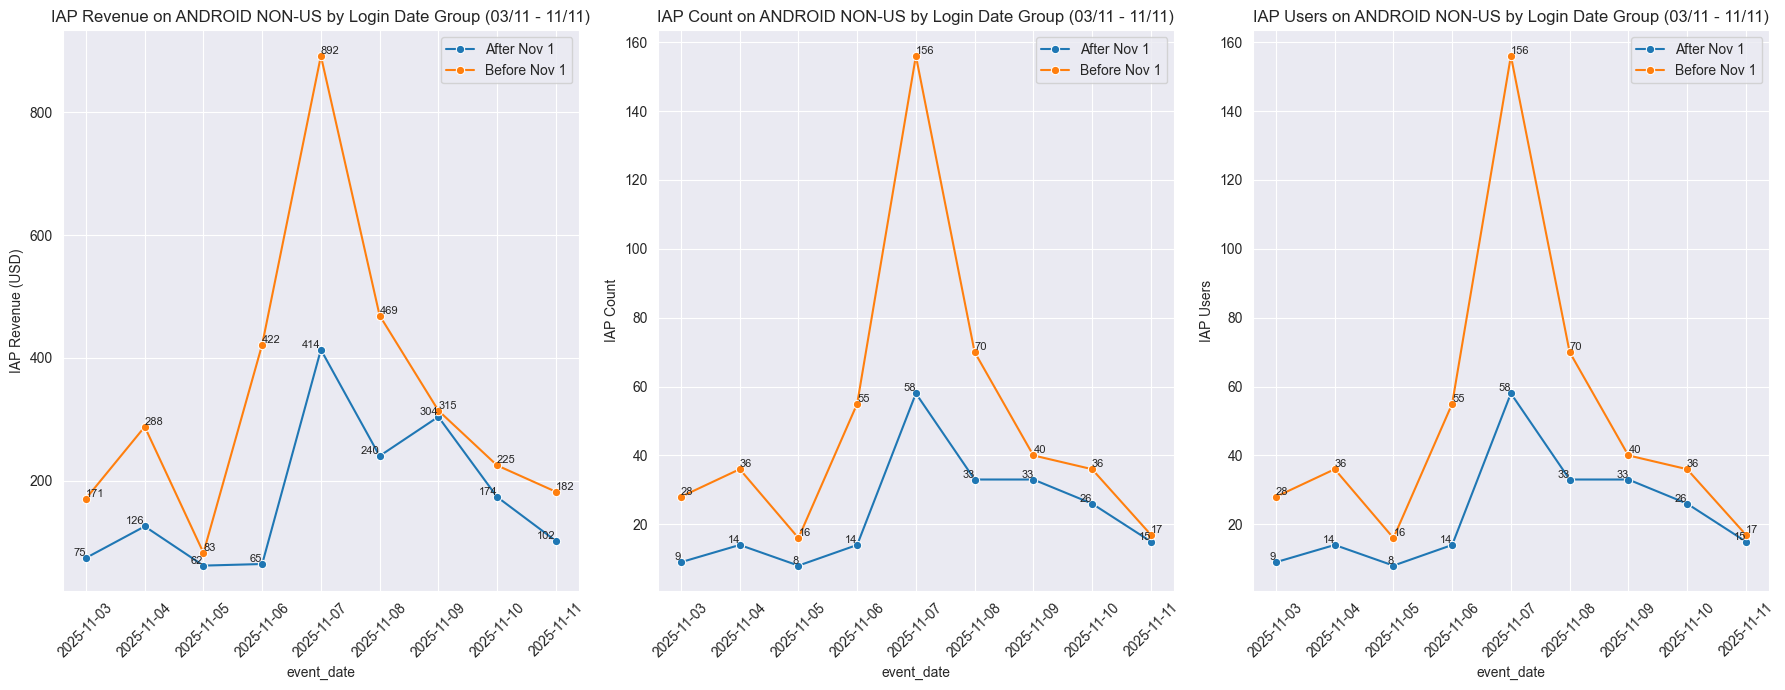

In [50]:
and_iap_data['login_date_group'] = np.where(
    and_iap_data['login_date'] < pd.to_datetime('2025-11-01'),
    'Before Nov 1',
    'After Nov 1'
)
and_iap_login_group = and_iap_data.groupby(['event_date', 'login_date_group']).agg(
    iap_revenue = ('event_value_in_usd', 'sum'),
    iap_count = ('event_timestamp', 'count'),
    iap_users = ('user_pseudo_id', 'nunique')
).reset_index()

fig, ax = plt.subplots(1,3, figsize=(18,7))
# Revenue plot
for group in and_iap_login_group['login_date_group'].unique():
    group_data = and_iap_login_group[and_iap_login_group['login_date_group'] == group]
    sns.lineplot(data=group_data, x='event_date', y='iap_revenue', label=group, marker='o', ax=ax[0])
    for idx, row in group_data.iterrows():
        ha = 'left' if group == 'Before Nov 1' else 'right'
        ax[0].text(row['event_date'], row['iap_revenue'], f'{row["iap_revenue"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')
ax[0].set_title(f'IAP Revenue on ANDROID NON-US by Login Date Group (03/11 - 11/11)')
ax[0].set_ylabel('IAP Revenue (USD)')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].tick_params(axis='x', rotation=45)
# Count plot
for group in and_iap_login_group['login_date_group'].unique():
    group_data = and_iap_login_group[and_iap_login_group['login_date_group'] == group]
    sns.lineplot(data=group_data, x='event_date', y='iap_count', label=group, marker='o', ax=ax[1])
    for idx, row in group_data.iterrows():
        ha = 'left' if group == 'Before Nov 1' else 'right'
        ax[1].text(row['event_date'], row['iap_count'], f'{row["iap_count"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')
ax[1].set_title(f'IAP Count on ANDROID NON-US by Login Date Group (03/11 - 11/11)')
ax[1].set_ylabel('IAP Count')
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].tick_params(axis='x', rotation=45)
# Users plot
for group in and_iap_login_group['login_date_group'].unique():
    group_data = and_iap_login_group[and_iap_login_group['login_date_group'] == group]
    sns.lineplot(data=group_data, x='event_date', y='iap_users', label=group, marker='o', ax=ax[2])
    for idx, row in group_data.iterrows():
        ha = 'left' if group == 'Before Nov 1' else 'right'
        ax[2].text(row['event_date'], row['iap_users'], f'{row["iap_users"]:.0f}',
                   fontsize=8, ha=ha, va='bottom')
ax[2].set_title(f'IAP Users on ANDROID NON-US by Login Date Group (03/11 - 11/11)')
ax[2].set_ylabel('IAP Users')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

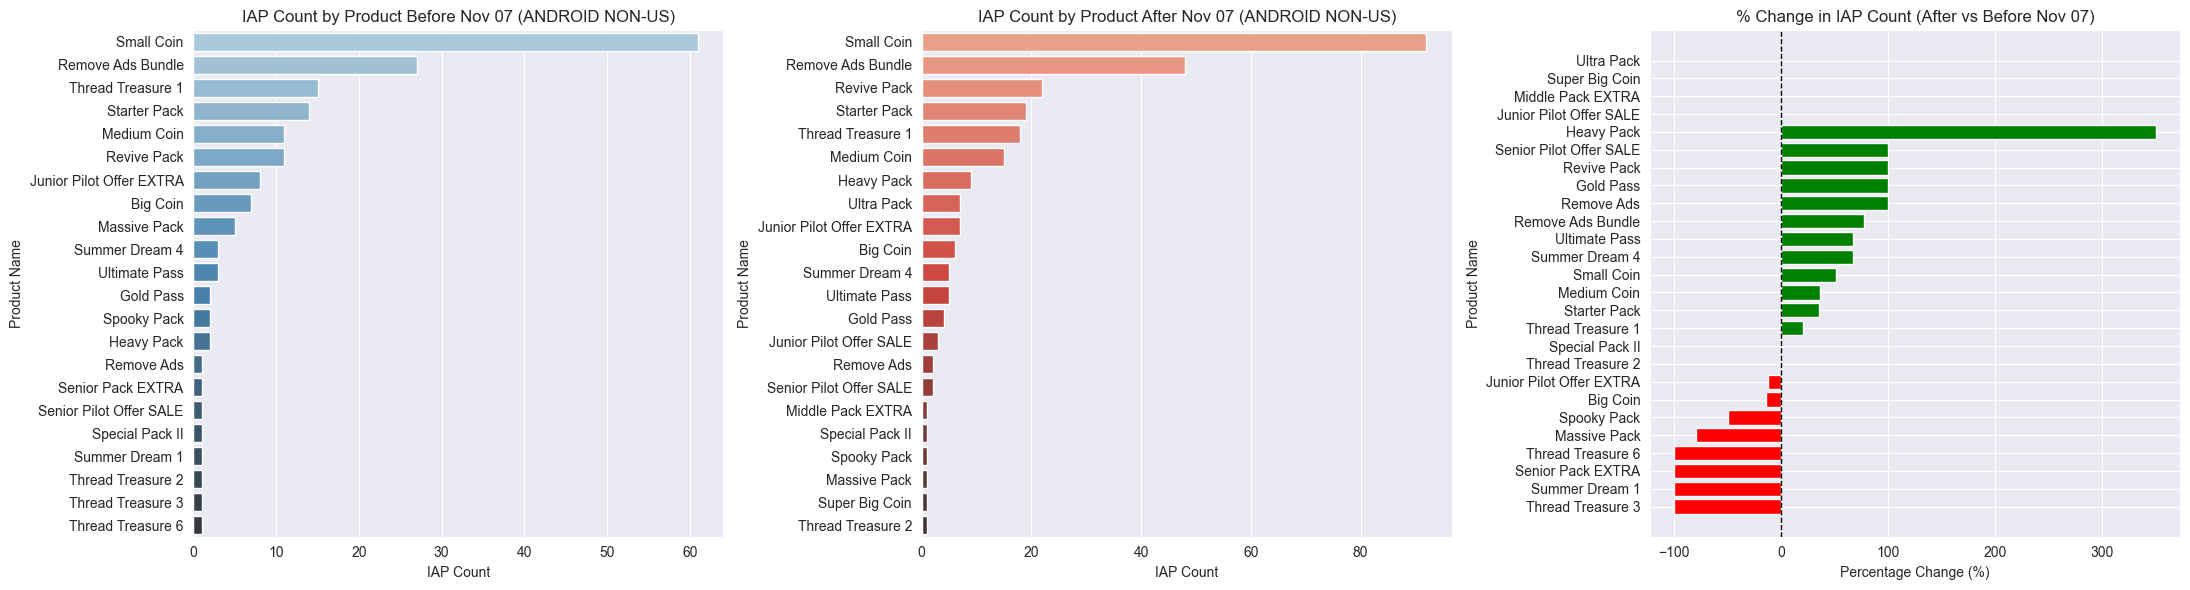

In [58]:
# Create product list mapping
product_list = iap.groupby('product_id')['product_name'].first().reset_index().to_dict(orient='records')
and_iap_data['product_name'] = and_iap_data['product_id'].map(
    {item['product_id']: item['product_name'] for item in product_list}
)

# Filter and aggregate before data
before_data = and_iap_data[and_iap_data['event_date'] <= pd.to_datetime('2025-11-06')].groupby('product_name').agg(
    iap_count=('event_timestamp', 'count'),
    avg_price=('event_value_in_usd', 'mean')
).reset_index().sort_values('iap_count', ascending=False)

# Filter and aggregate after data
after_data = and_iap_data[and_iap_data['event_date'] >= pd.to_datetime('2025-11-08')].groupby('product_name').agg(
    iap_count=('event_timestamp', 'count'),
    avg_price=('event_value_in_usd', 'mean')
).reset_index().sort_values('iap_count', ascending=False)

# Calculate percentage change
comparison = pd.merge(before_data, after_data, on='product_name', how='outer', suffixes=('_before', '_after'))
comparison = comparison.fillna(0)
comparison['pct_change'] = ((comparison['iap_count_after'] - comparison['iap_count_before']) /
                             comparison['iap_count_before'].replace(0, np.nan)) * 100
comparison = comparison.sort_values('pct_change', ascending=True)

# Compute colors: green for positive, red for negative/zero, gray for NA
colors = []
for val in comparison['pct_change']:
    if pd.isna(val):
        colors.append('gray')
    elif val > 0:
        colors.append('green')
    else:
        colors.append('red')

# Create plots
fig, ax = plt.subplots(1, 3, figsize=(22, 6))

# Before plot - assign hue to suppress warning
sns.barplot(data=before_data, x='iap_count', y='product_name', hue='product_name', ax=ax[0], palette='Blues_d', legend=False)
ax[0].set_title('IAP Count by Product Before Nov 07 (ANDROID NON-US)')
ax[0].set_xlabel('IAP Count')
ax[0].set_ylabel('Product Name')

# After plot - assign hue to suppress warning
sns.barplot(data=after_data, x='iap_count', y='product_name', hue='product_name', ax=ax[1], palette='Reds_d', legend=False)
ax[1].set_title('IAP Count by Product After Nov 07 (ANDROID NON-US)')
ax[1].set_xlabel('IAP Count')
ax[1].set_ylabel('Product Name')

# Percentage change plot with conditional colors
ax[2].barh(comparison['product_name'], comparison['pct_change'].fillna(0), color=colors)
ax[2].set_title('% Change in IAP Count (After vs Before Nov 07)')
ax[2].set_xlabel('Percentage Change (%)')
ax[2].set_ylabel('Product Name')
ax[2].axvline(x=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

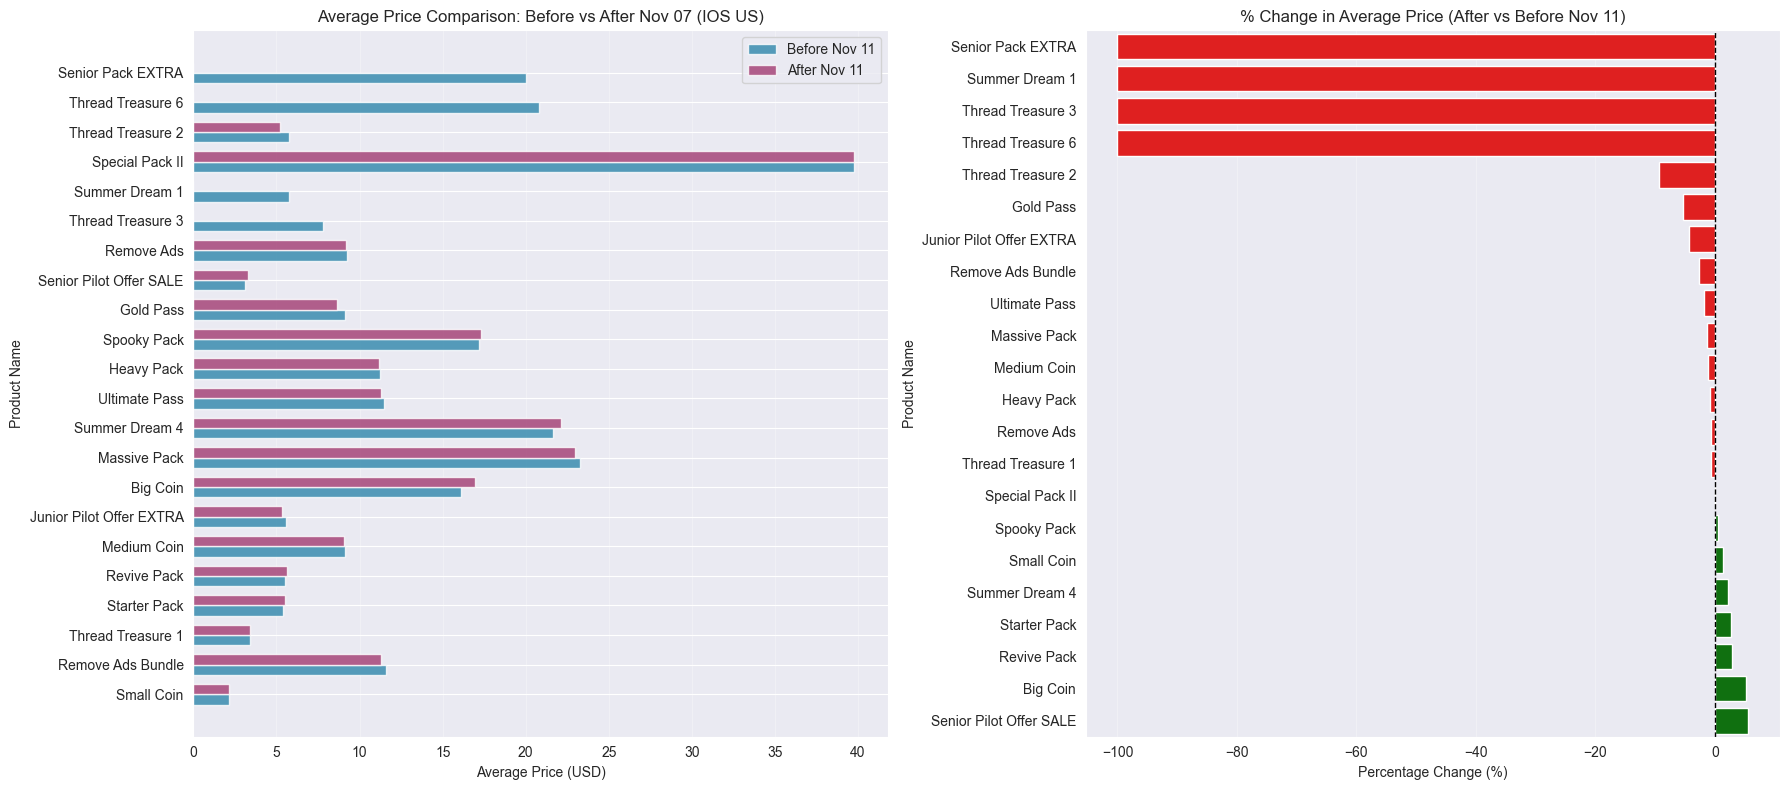

In [59]:
# Average price comparison
comparison_price = comparison.sort_values('iap_count_before', ascending=False)
comparison_price = comparison_price[comparison_price['iap_count_before'] > 0]

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Before vs After average price
x_pos = np.arange(len(comparison_price))
width = 0.35

bars1 = ax[0].barh(x_pos - width/2, comparison_price['avg_price_before'], width, label='Before Nov 11', color='#2E86AB', alpha=0.8)
bars2 = ax[0].barh(x_pos + width/2, comparison_price['avg_price_after'], width, label='After Nov 11', color='#A23B72', alpha=0.8)

ax[0].set_yticks(x_pos)
ax[0].set_yticklabels(comparison_price['product_name'])
ax[0].set_xlabel('Average Price (USD)')
ax[0].set_ylabel('Product Name')
ax[0].set_title('Average Price Comparison: Before vs After Nov 07 (IOS US)')
ax[0].legend()
ax[0].grid(axis='x', alpha=0.3)

# Percentage change in average price
comparison_price['price_pct_change'] = ((comparison_price['avg_price_after'] - comparison_price['avg_price_before']) / comparison_price['avg_price_before'].replace(0, np.nan)) * 100
comparison_price_sorted = comparison_price.sort_values('price_pct_change', ascending=True)

colors_price = ['green' if x > 0 else 'red' for x in comparison_price_sorted['price_pct_change']]
sns.barplot(data=comparison_price_sorted, x='price_pct_change', y='product_name', hue='product_name', ax=ax[1], palette=colors_price, legend=False)
ax[1].set_title('% Change in Average Price (After vs Before Nov 11)')
ax[1].set_xlabel('Percentage Change (%)')
ax[1].set_ylabel('Product Name')
ax[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
ax[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

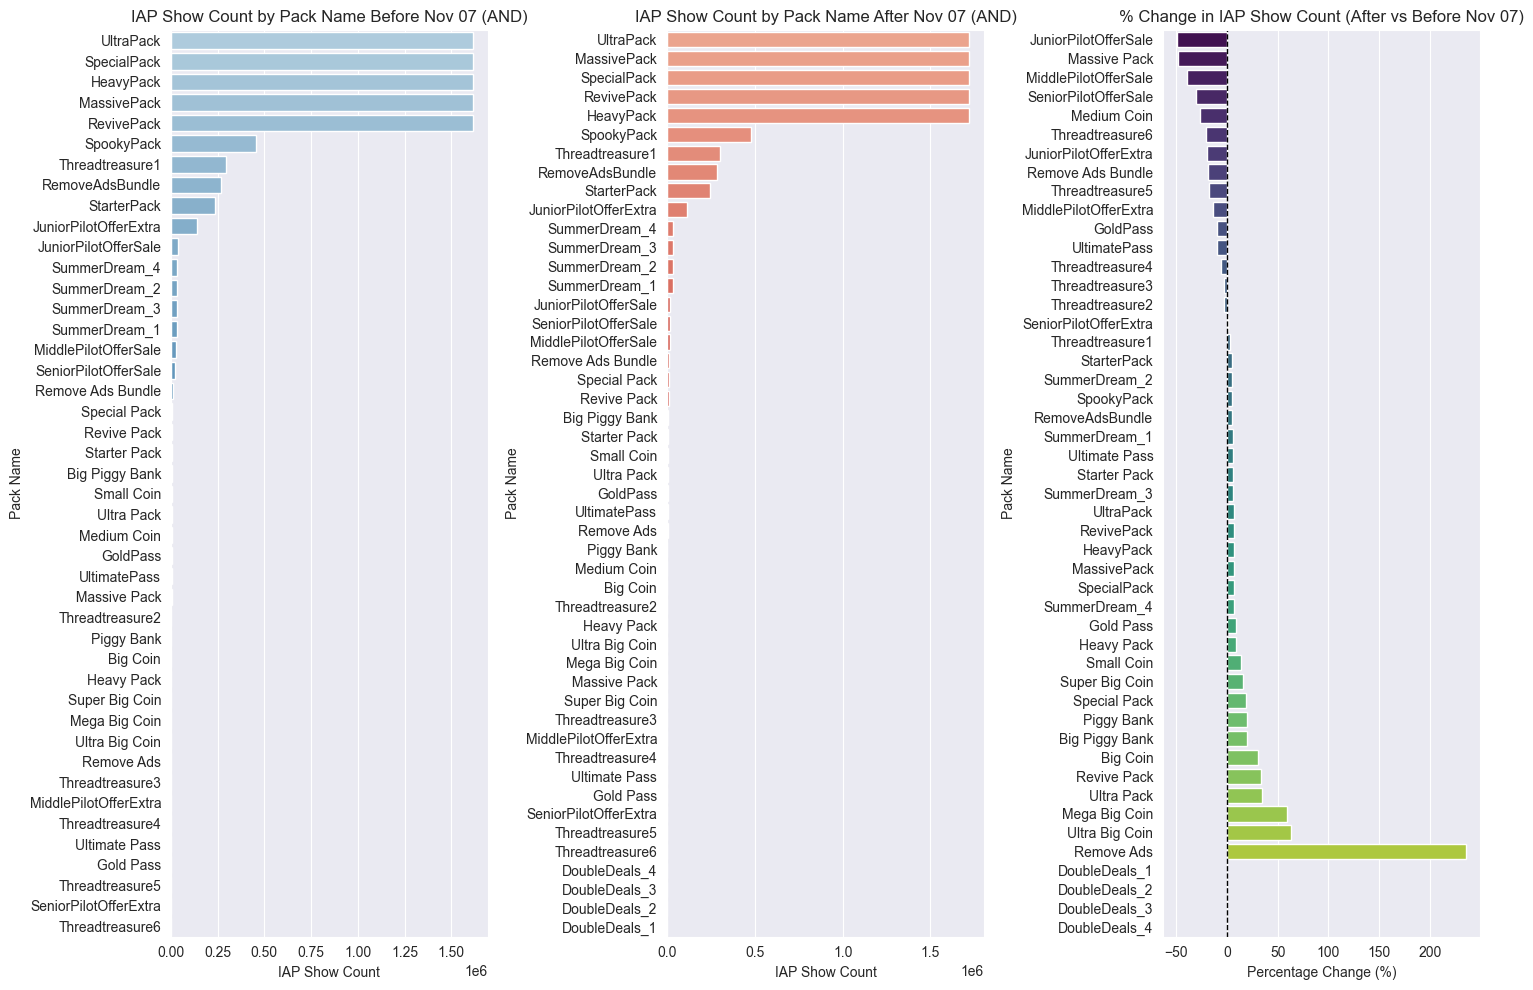

In [60]:
and_iap_show = iap_show_exp[
    (iap_show_exp['event_date'].between(pd.to_datetime('2025-11-03'), pd.to_datetime('2025-11-11'))) &
    (iap_show_exp['version'] == '1.7.2')
]
and_iap_show_before = and_iap_show[and_iap_show['event_date'] <= pd.to_datetime('2025-11-06')].groupby('pack_name').agg(
    show_count = ('total_show', 'sum')
).reset_index().sort_values('show_count', ascending=False)
and_iap_show_after = and_iap_show[and_iap_show['event_date'] >= pd.to_datetime('2025-11-08')].groupby('pack_name').agg(
    show_count = ('total_show', 'sum')
).reset_index().sort_values('show_count', ascending=False)

fig, ax = plt.subplots(1,3, figsize=(15,10))
sns.barplot(data=and_iap_show_before, x='show_count', y='pack_name', hue='pack_name', ax=ax[0], palette='Blues_d', legend=False)
ax[0].set_title('IAP Show Count by Pack Name Before Nov 07 (AND)')
ax[0].set_xlabel('IAP Show Count')
ax[0].set_ylabel('Pack Name')
sns.barplot(data=and_iap_show_after, x='show_count', y='pack_name', hue='pack_name', ax=ax[1], palette='Reds_d', legend=False)
ax[1].set_title('IAP Show Count by Pack Name After Nov 07 (AND)')
ax[1].set_xlabel('IAP Show Count')
ax[1].set_ylabel('Pack Name')
# Percentage change
comparison_show = pd.merge(and_iap_show_before, and_iap_show_after, on='pack_name', how='outer', suffixes=('_before', '_after'))
comparison_show = comparison_show.fillna(0)
comparison_show['pct_change'] = ((comparison_show['show_count_after'] - comparison_show['show_count_before']) / comparison_show['show_count_before'].replace(0, np.nan)) * 100
comparison_show = comparison_show.sort_values('pct_change', ascending=True)
sns.barplot(data=comparison_show, x='pct_change', y='pack_name', hue='pack_name', ax=ax[2], palette='viridis', legend=False)
ax[2].set_title('% Change in IAP Show Count (After vs Before Nov 07)')
ax[2].set_xlabel('Percentage Change (%)')
ax[2].set_ylabel('Pack Name')
ax[2].axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

In [61]:
and_user_play_time = user_play_time[user_play_time['version'] == '1.7.2']

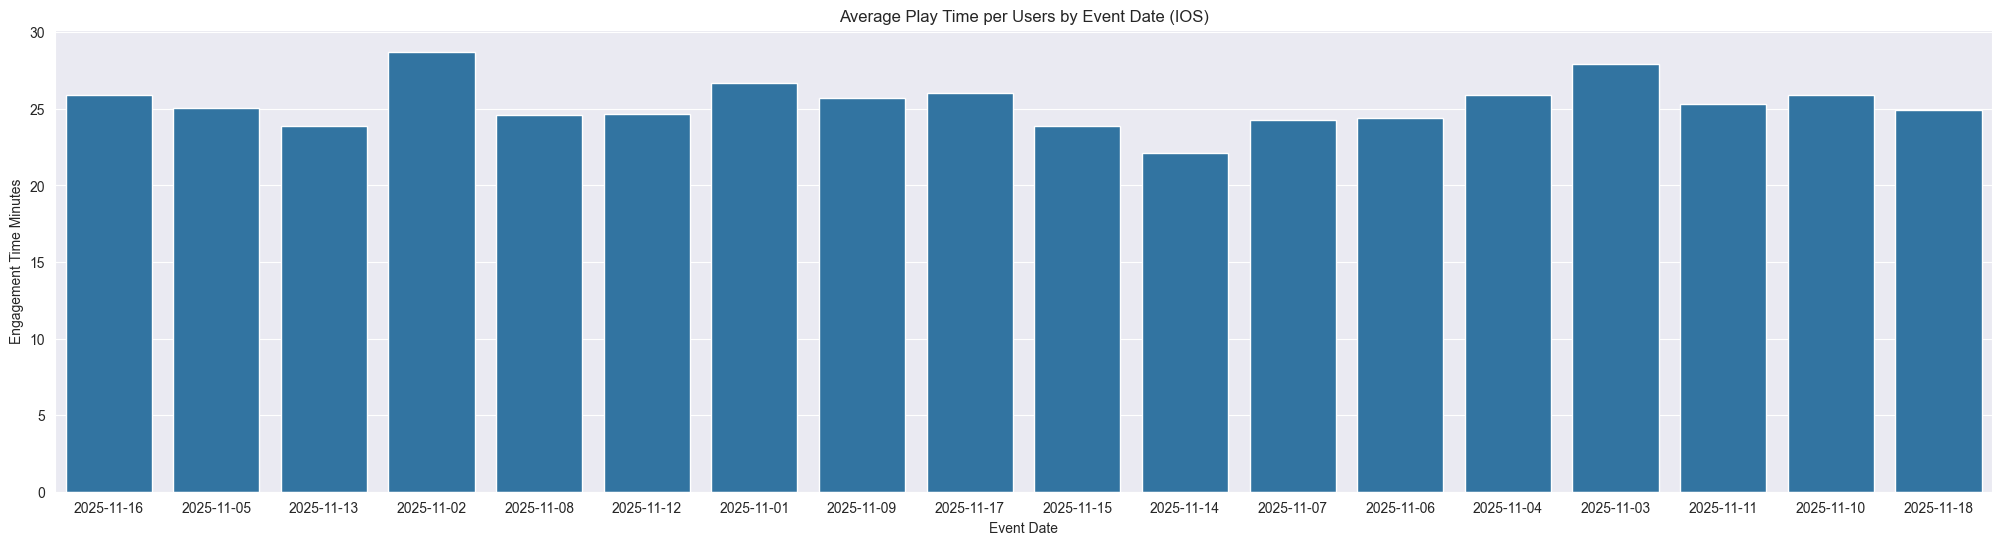

In [62]:
fig, ax = plt.subplots(figsize=(25,6))
sns.barplot(data=ios_user_play_time, x='event_date', y='avg_play_time_minutes')
ax.set_title('Average Play Time per Users by Event Date (IOS)')
ax.set_xlabel('Event Date')
ax.set_ylabel('Engagement Time Minutes')
plt.show()